# Imports & Functions

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.stats import shapiro, f_oneway, kruskal, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
import pickle
import os


# -------------------------
# 0) Data helpers
# -------------------------
def get_table(
    data_dict: dict,
    year: str,
    table: str,
) -> pd.DataFrame:
    """Fetch a sheet/table from data_dict and return a copy."""
    return data_dict[year][table].copy()


def filter_surface_landuse_region(
    df: pd.DataFrame,
    *,
    phuid: int = 1,
    phsampleuid: int = 1,
    survey_id: int | None = None,
    regions: list[str] | None = None,
    phuid_col: str = "PHUID",
    sample_col: str = "PHSampleUID",
    survey_col: str = "SurveyID",
    region_col: str = "Location",
) -> pd.DataFrame:
    """
    Standard filter for your workflow:
    - surface: PHUID==1
    - target sample: PHSampleUID==1
    - land use: SurveyID==X (optional)
    - regions in [..] (optional)
    """
    out = df.copy()
    out = out[(out[phuid_col] == phuid) & (out[sample_col] == phsampleuid)]
    if survey_id is not None:
        out = out[out[survey_col] == survey_id]
    if regions is not None:
        out = out[out[region_col].isin(regions)]
    return out


def to_numeric_clean(df: pd.DataFrame, col: str) -> pd.Series:
    """Coerce to numeric and drop NaNs."""
    return pd.to_numeric(df[col], errors="coerce").dropna()

def compute_soil_texture_ratio(
    df_physical: pd.DataFrame,
    *,
    regions: list[str],
    region_col: str = "Location",
    clay_col: str | None = None,
    silt_col: str | None = None,
    sand_col: str | None = None,
    # 如果暂时只能用倒数列（与你现有数据兼容）
    clay_iloc: int = -5,
    silt_iloc: int = -4,
    sand_iloc: int = -3,
    round_digits: int = 1,
) -> pd.DataFrame:
    """
    计算各区域 Soil Texture（clay / sand / silt）百分比
    """
    out = {}

    for r in regions:
        sub = df_physical[df_physical[region_col] == r]

        if clay_col and silt_col and sand_col:
            clay = pd.to_numeric(sub[clay_col], errors="coerce").sum()
            silt = pd.to_numeric(sub[silt_col], errors="coerce").sum()
            sand = pd.to_numeric(sub[sand_col], errors="coerce").sum()
        else:
            clay = pd.to_numeric(sub.iloc[:, clay_iloc], errors="coerce").sum()
            silt = pd.to_numeric(sub.iloc[:, silt_iloc], errors="coerce").sum()
            sand = pd.to_numeric(sub.iloc[:, sand_iloc], errors="coerce").sum()

        total = clay + silt + sand

        out[r] = {
            "clay": clay / total * 100 if total != 0 else np.nan,
            "sand": sand / total * 100 if total != 0 else np.nan,
            "silt": silt / total * 100 if total != 0 else np.nan,
        }

    return pd.DataFrame.from_dict(out, orient="index").round(round_digits)

def plot_soil_texture_grouped_bar(
    ratio_df: pd.DataFrame,
    *,
    regions_order: list[str],
    textures=("clay", "sand", "silt"),
    palette: dict,
    figsize=(12, 5),
    dpi=150,
    bar_w=0.22,
    gap=0.30,
    y_max=105,
    value_fmt="{:.1f}%",
    label_offset=2.0,
    xlabel="Location",
    ylabel="Average Percentage (%)",
    legend_title="Soil Texture",
    fig_bottom=0.28,
):
    """
    Soil texture 分组柱状图（矩形）
    """
    tex_cfg = palette["textures"]
    axis_c = palette.get("axis_text_color", "#6B6B6B")
    value_c = palette.get("value_color", "#6B6B6B")
    grid_alpha = palette.get("grid_alpha", 0.35)

    df = ratio_df.reindex(regions_order)
    values = df[list(textures)].to_numpy()

    x = np.arange(len(regions_order))
    offsets = np.array([-gap, 0.0, gap])

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for j, tex in enumerate(textures):
        cfg = tex_cfg[tex]
        ax.bar(
            x + offsets[j],
            values[:, j],
            width=bar_w,
            color=cfg["face"],
            edgecolor=cfg["edge"],
            hatch=cfg.get("hatch"),
            linewidth=0.0,
            alpha=0.95,
        )

        for i, v in enumerate(values[:, j]):
            if np.isfinite(v):
                ax.text(
                    x[i] + offsets[j],
                    v + label_offset,
                    value_fmt.format(v),
                    ha="center",
                    va="bottom",
                    fontsize=12,
                    color=value_c,
                )

    ax.set_xlim(-0.6, len(regions_order) - 1 + 0.6)
    ax.set_ylim(0, y_max)
    ax.set_xticks(x)
    ax.set_xticklabels(regions_order, fontsize=12, color=axis_c)
    ax.tick_params(axis="x", pad=16)

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12, fontweight="bold", color="#4B4B4B")

    ax.yaxis.grid(True, alpha=grid_alpha)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    handles = [
        Patch(
            facecolor=tex_cfg[t]["face"],
            edgecolor=tex_cfg[t]["edge"],
            hatch=tex_cfg[t].get("hatch"),
            label=tex_cfg[t]["label"],
        )
        for t in textures
    ]

    fig.subplots_adjust(bottom=fig_bottom)
    fig.text(0.07, 0.06, legend_title, fontsize=12, fontweight="bold")

    fig.legend(
        handles=handles,
        loc="lower left",
        bbox_to_anchor=(0.18, 0.035),
        ncol=len(handles),
        frameon=False,
        fontsize=12,
    )

    plt.show()
    return fig, ax

def summary_bulk_density_by_region(
    df_physical: pd.DataFrame,
    *,
    regions: list[str],
    region_col: str = "Location",
    bulk_col: str = "BULKDENS",
    round_digits: int = 2,
) -> pd.DataFrame:
    """
    计算各区域 Bulk Density 均值
    """
    out = {}
    for r in regions:
        sub = df_physical[df_physical[region_col] == r]
        x = pd.to_numeric(sub[bulk_col], errors="coerce").dropna()
        out[r] = {"Bulk Density (g/cm³)": x.mean() if len(x) else np.nan}

    return pd.DataFrame.from_dict(out, orient="index").round(round_digits)

def plot_bulk_density_bar(
    df_region: pd.DataFrame,
    *,
    regions: list[str],
    value_col: str,
    palette: dict,
    ylabel: str = "Bulk Density (g/cm³)",
    figsize=(12, 3.4),
    dpi=150,
    hatch="..",
    value_fmt="{:.2f}",
):
    vals = df_region.reindex(regions)[value_col].to_numpy(dtype=float)
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    bars = ax.bar(
        x,
        vals,
        width=0.28,
        color=palette["base"],
        edgecolor=palette["edge"],
        hatch=hatch,
        linewidth=0.0,
        alpha=0.95,
    )

    for rect, v in zip(bars, vals):
        if np.isfinite(v):
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                v * 0.55,
                value_fmt.format(v),
                ha="center",
                va="center",
                fontsize=13,
                color=palette.get("value_text", "white"),
            )

    ax.set_xticks(x)
    ax.set_xticklabels(regions, fontsize=12, color="#7A7A7A")
    ax.set_ylabel(ylabel, fontsize=12)

    ax.yaxis.grid(True, alpha=0.35)
    ax.set_axisbelow(True)

    ax.tick_params(axis="y", labelleft=False, length=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.show()
    return fig, ax
# -------------------------
# 1) Descriptive stats table
# -------------------------
def summary_by_region(
    df: pd.DataFrame,
    *,
    value_col: str,
    regions: list[str],
    landuse_name: str = "Industrial",
    region_col: str = "Location",
    round_digits: int = 2,
) -> pd.DataFrame:
    """
    Return table indexed by (LandUse, Region):
    Mean±SE, Median, Min, Max, n
    """
    rows = []
    for region in regions:
        sub = df[df[region_col] == region]
        x = to_numeric_clean(sub, value_col)

        n = int(x.size)
        mean = float(x.mean()) if n else np.nan
        median = float(x.median()) if n else np.nan
        min_val = float(x.min()) if n else np.nan
        max_val = float(x.max()) if n else np.nan
        se = float(x.std(ddof=1) / np.sqrt(n)) if n > 1 else np.nan

        rows.append({
            "LandUse": landuse_name,
            "Region": region,
            "Mean ± se": f"{mean:.{round_digits}f} ± {se:.{round_digits}f}" if np.isfinite(mean) else "",
            "Median": round(median, round_digits) if np.isfinite(median) else np.nan,
            "Min": round(min_val, round_digits) if np.isfinite(min_val) else np.nan,
            "Max": round(max_val, round_digits) if np.isfinite(max_val) else np.nan,
            "n": n,
        })

    out = (
        pd.DataFrame(rows)
        .set_index(["LandUse", "Region"])
        .loc[:, ["Mean ± se", "Median", "Min", "Max", "n"]]
    )
    return out


# -------------------------
# 2) Regional difference test + letters
# -------------------------
def regional_samples(
    df: pd.DataFrame,
    *,
    value_col: str,
    regions: list[str],
    region_col: str = "Location",
) -> dict[str, np.ndarray]:
    """Return {region: np.array(values)}."""
    tmp = df.copy()
    tmp[value_col] = pd.to_numeric(tmp[value_col], errors="coerce")
    return {r: tmp.loc[tmp[region_col] == r, value_col].dropna().to_numpy() for r in regions}


def shapiro_normality(samples: dict[str, np.ndarray], alpha: float = 0.05) -> pd.DataFrame:
    """Shapiro test per region (len<3 returns NaN, Normal? False)."""
    rows = []
    for r, x in samples.items():
        if len(x) < 3:
            rows.append({"Region": r, "n": len(x), "W": np.nan, "p": np.nan, "Normal?": False})
        else:
            W, p = shapiro(x)
            rows.append({"Region": r, "n": len(x), "W": W, "p": p, "Normal?": (p >= alpha)})
    return pd.DataFrame(rows).set_index("Region")


def overall_test(samples: dict[str, np.ndarray], regions: list[str], alpha: float = 0.05) -> pd.DataFrame:
    """
    Decide ANOVA vs Kruskal based on Shapiro normality across all regions.
    Return a one-row table with test name, statistic, p.
    """
    df_norm = shapiro_normality(samples, alpha=alpha)
    all_normal = bool(df_norm["Normal?"].all())
    x_list = [samples[r] for r in regions]

    if all_normal:
        stat, p = f_oneway(*x_list)
        return pd.DataFrame([{"Test": "One-way ANOVA", "Statistic": stat, "p_value": p}])
    else:
        stat, p = kruskal(*x_list)
        return pd.DataFrame([{"Test": "Kruskal–Wallis", "Statistic": stat, "p_value": p}])


def posthoc_tests(
    samples: dict[str, np.ndarray],
    regions: list[str],
    alpha: float = 0.05,
) -> tuple[pd.DataFrame, dict[frozenset, bool], bool]:
    """
    If all normal -> Welch t-tests (LSD-style, no correction)
    Else -> Mann-Whitney + Holm correction
    Return:
      - df_posthoc
      - sig_dict: frozenset({r1,r2}) -> True if significantly different
      - all_normal
    """
    df_norm = shapiro_normality(samples, alpha=alpha)
    all_normal = bool(df_norm["Normal?"].all())

    post_rows = []
    sig_dict: dict[frozenset, bool] = {}

    if all_normal:
        for r1, r2 in combinations(regions, 2):
            x1, x2 = samples[r1], samples[r2]
            t_stat, p_pair = ttest_ind(x1, x2, equal_var=False, nan_policy="omit")
            sig = bool(p_pair < alpha)
            sig_dict[frozenset([r1, r2])] = sig
            post_rows.append({
                "Comparison": f"{r1} vs {r2}",
                "Test": "Welch t-test (LSD-style)",
                "Statistic": t_stat,
                "p_value": p_pair,
                "Significant": sig,
            })
        df_post = pd.DataFrame(post_rows).sort_values("p_value")
    else:
        raw_p = []
        pair_keys = []
        for r1, r2 in combinations(regions, 2):
            x1, x2 = samples[r1], samples[r2]
            p_pair = mannwhitneyu(x1, x2, alternative="two-sided").pvalue
            raw_p.append(p_pair)
            pair_keys.append((r1, r2))
            post_rows.append({"Comparison": f"{r1} vs {r2}", "Test": "Mann–Whitney U", "p_raw": p_pair})

        reject, p_adj, _, _ = multipletests(raw_p, alpha=alpha, method="holm")
        for i, (r1, r2) in enumerate(pair_keys):
            sig = bool(reject[i])
            sig_dict[frozenset([r1, r2])] = sig
            post_rows[i]["p_adj_holm"] = p_adj[i]
            post_rows[i]["Significant"] = sig

        df_post = pd.DataFrame(post_rows).sort_values("p_adj_holm")

    return df_post, sig_dict, all_normal


def assign_letters_from_sig(
    summary_df: pd.DataFrame,
    sig_dict: dict[frozenset, bool],
    *,
    landuse_name: str,
    regions: list[str],
) -> dict[str, str]:
    """
    Letter grouping:
    - same letter => NOT significantly different
    - different letters => significantly different
    Letters assigned from high mean to low mean.
    """
    def extract_mean(mean_se_str: str) -> float:
        try:
            return float(mean_se_str.split("±")[0].strip())
        except Exception:
            return np.nan

    tmp = summary_df.reset_index().copy()
    tmp = tmp[tmp["LandUse"] == landuse_name].copy()
    tmp["MeanValue"] = tmp["Mean ± se"].apply(extract_mean)
    tmp = tmp[tmp["Region"].isin(regions)].sort_values("MeanValue", ascending=False)

    letters: dict[str, str] = {}
    used_letters: list[str] = []

    for region in tmp["Region"].tolist():
        assigned = False
        for letter in used_letters:
            compatible = True
            for r_assigned, l_assigned in letters.items():
                if l_assigned == letter:
                    if sig_dict.get(frozenset([region, r_assigned]), False):
                        compatible = False
                        break
            if compatible:
                letters[region] = letter
                assigned = True
                break
        if not assigned:
            new_letter = chr(ord("a") + len(used_letters))
            used_letters.append(new_letter)
            letters[region] = new_letter

    return letters


def append_letters_to_summary(
    summary_df: pd.DataFrame,
    letters: dict[str, str],
    *,
    landuse_name: str,
    regions: list[str],
) -> pd.DataFrame:
    """Append letters after Mean±se for the given landuse/regions."""
    out = summary_df.copy()
    for region in regions:
        idx = (landuse_name, region)
        if idx in out.index:
            s = out.loc[idx, "Mean ± se"]
            out.loc[idx, "Mean ± se"] = f"{s} {letters.get(region, '')}".rstrip()
    return out


# -------------------------
# 3) Class bins (pH / EC) table
# -------------------------
def class_distribution_by_region(
    df: pd.DataFrame,
    *,
    value_col: str,
    bins: list[tuple[float, float, str]],
    regions: list[str],
    region_col: str = "Location",
    right_inclusive: bool = True,
    round_digits: int = 1,
) -> pd.DataFrame:
    """
    Return MultiIndex table: (Region, Class) -> Percentage, Count
    """
    tmp = df.copy()
    tmp[value_col] = pd.to_numeric(tmp[value_col], errors="coerce")

    rows = []
    for region in regions:
        sub = tmp[tmp[region_col] == region]
        x = sub[value_col].dropna()
        total_n = int(x.shape[0])

        for low, high, label in bins:
            if np.isinf(low):
                mask = x < high if right_inclusive else x <= high
            elif np.isinf(high):
                mask = x > low if right_inclusive else x >= low
            else:
                if right_inclusive:
                    mask = (x >= low) & (x <= high)
                else:
                    mask = (x >= low) & (x < high)

            count = int(mask.sum())
            percent = (count / total_n * 100.0) if total_n > 0 else np.nan

            rows.append({
                "Region": region,
                "Class": label,
                "Percentage (%)": round(float(percent), round_digits) if np.isfinite(percent) else np.nan,
                "Count": count,
            })

    out = pd.DataFrame(rows).set_index(["Region", "Class"])
    return out


# -------------------------
# 4) Plot: horizontal stacked percent bars
# -------------------------
def plot_stacked_percent_barh(
    pct_table: pd.DataFrame,
    *,
    regions_order: list[str],
    class_order: list[str],
    colors: dict[str, str] | None = None,
    label_min: float = 3.0,
    figsize=(12, 3.6),
    dpi: int = 150,
    legend_ncol: int = 4,
    legend_loc: str = "lower center",
    legend_bbox=(0.5, 0.02),
):
    """
    pct_table: MultiIndex (Region, Class) with "Percentage (%)"
    """
    pct_wide = (
        pct_table["Percentage (%)"]
        .unstack("Class")
        .fillna(0.0)
        .reindex(regions_order)
    )

    # ensure all classes exist
    for c in class_order:
        if c not in pct_wide.columns:
            pct_wide[c] = 0.0
    pct_wide = pct_wide[class_order]

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    y = np.arange(pct_wide.shape[0])
    left = np.zeros(pct_wide.shape[0])

    for cls in class_order:
        vals = pct_wide[cls].to_numpy(dtype=float)
        ax.barh(
            y, vals, left=left, height=0.55,
            color=(colors[cls] if colors else None),
            edgecolor="none",
        )
        for i, v in enumerate(vals):
            if v >= label_min:
                ax.text(left[i] + v / 2, y[i], f"{v:.1f}%", ha="center", va="center", fontsize=11, color="white")
        left += vals

    ax.set_yticks(y)
    ax.set_yticklabels(pct_wide.index, fontsize=12, color="#4B4B4B")
    ax.set_xlim(0, 100)
    ax.xaxis.grid(True, linestyle="-", linewidth=0.7, alpha=0.35)
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", labelbottom=False, length=0)

    for sp in ["top", "right", "bottom", "left"]:
        ax.spines[sp].set_visible(False)

    handles = [Patch(facecolor=(colors[c] if colors else "gray"), label=c) for c in class_order]
    fig.subplots_adjust(bottom=0.28)
    fig.legend(
        handles=handles,
        loc=legend_loc,
        bbox_to_anchor=legend_bbox,
        ncol=legend_ncol,
        frameon=False,
        fontsize=10,
        handlelength=1.2,
        handleheight=1.2,
        columnspacing=1.6,
    )
    plt.show()
    return fig, ax


# -------------------------
# 5) Plot: box + jitter + mean marker
# -------------------------
def plot_box_jitter_mean(
    df: pd.DataFrame,
    *,
    value_col: str,
    regions_order: list[str],
    region_col: str = "Location",
    exclude_below: float | None = None,
    ylabel: str = "Value",
    figsize=(7.2, 4.8),
    dpi: int = 150,
    rng_seed: int = 42,
    facecolor: str = "#C79A78",
):
    """
    Boxplot per region with all points + mean marker.
    """
    data_by_region = []
    for region in regions_order:
        sub = df[df[region_col] == region].copy()
        x = pd.to_numeric(sub[value_col], errors="coerce").dropna()
        if exclude_below is not None:
            x = x[x >= exclude_below]
        data_by_region.append(x.to_numpy())

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.boxplot(
        data_by_region,
        widths=0.30,
        patch_artist=True,
        showfliers=True,
        flierprops=dict(marker="+", markersize=6, markerfacecolor="none",
                        markeredgecolor="red", markeredgewidth=1.0, linestyle="none"),
        boxprops=dict(facecolor=facecolor, edgecolor="#333333", linewidth=1.0, alpha=0.85),
        medianprops=dict(color="#333333", linewidth=1.2),
        whiskerprops=dict(color="#333333", linewidth=1.0),
        capprops=dict(color="#333333", linewidth=1.0),
    )

    rng = np.random.default_rng(rng_seed)
    for i, arr in enumerate(data_by_region, start=1):
        if arr.size == 0:
            continue
        jitter = rng.normal(0.0, 0.02, size=arr.size)
        ax.scatter(np.full(arr.size, i) + jitter, arr, s=2, c="black", linewidths=0, zorder=2)

    means = [np.mean(arr) if arr.size else np.nan for arr in data_by_region]
    xpos = np.arange(1, len(regions_order) + 1)
    ax.scatter(xpos, means, marker="^", s=80, c="#2C2C2C", linewidths=0, zorder=4)

    ax.set_xticks(xpos)
    ax.set_xticklabels(regions_order, fontsize=11, color="#7A7A7A")
    ax.set_ylabel(ylabel, fontsize=12, color="#7A7A7A")
    for tick in ax.get_yticklabels():
        tick.set_color("#7A7A7A")

    ax.grid(axis="y", linestyle="-", alpha=0.35)
    ax.set_axisbelow(True)
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)
    ax.tick_params(axis="both", which="both", length=0)

    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_mean_bar_single_year(
    summary_df,
    *,
    regions: list[str],
    landuse_name: str,
    palette: dict,
    ylabel: str,
    value_from: str = "Mean ± se",
    figsize=(12, 3.4),
    dpi: int = 150,
    show_values: bool = True,
    value_fmt: str = "{:.2f}",
    value_ypos_ratio: float = 0.55,   # 数字在柱内的相对位置
    legend_label: str = "Surface",
    legend: bool = True,
):
    """
    summary_df: MultiIndex (LandUse, Region) 表，至少包含 value_from 列（例如 'Mean ± se'）
    逻辑：从 'Mean ± se' 提取均值，画三地区柱形图，柱内标注数值
    """
    def extract_mean(x):
        # 支持 "7.12 ± 0.10 a" 或 "7.12 ± 0.10"
        if not isinstance(x, str):
            return np.nan
        left = x.split("±")[0].strip()  # "7.12" 或 "7.12 a"(不会发生，但防一下)
        # 如果后面带字母，把非数值剔除
        try:
            return float(left.split()[0])
        except Exception:
            return np.nan

    # 取均值数组
    means = []
    for r in regions:
        idx = (landuse_name, r)
        if idx not in summary_df.index:
            means.append(np.nan)
            continue
        means.append(extract_mean(summary_df.loc[idx, value_from]))

    means = np.array(means, dtype=float)

    # palette
    bar_face = palette.get("base", "#C79A78")
    bar_edge = palette.get("edge", bar_face)
    grid_c   = palette.get("grid", None)
    text_c   = palette.get("value_text", "white")  # 可选：柱内文字颜色

    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    bars = ax.bar(
        x,
        means,
        width=0.28,
        color=bar_face,
        edgecolor=bar_edge,
        linewidth=0.0,
        alpha=0.95
    )

    # 柱内白色数值
    if show_values:
        for rect, v in zip(bars, means):
            if np.isnan(v):
                continue

            # --- 3 significant digits, keep trailing zeros (e.g., 0.70) ---
            if v == 0:
                s = "0.00"
            else:
                digits = int(math.floor(math.log10(abs(v)))) + 1
                decimals_sig = max(0, 3 - digits)
                decimals = min(decimals_sig, 2)
                s = f"{v:.{decimals}f}"

            ax.text(
                rect.get_x() + rect.get_width() / 2,
                v * value_ypos_ratio,
                s,
                ha="center",
                va="center",
                fontsize=13,
                color=text_c
            )

    # x 轴
    ax.set_xticks(x)
    ax.set_xticklabels(regions, fontsize=12, color="#7A7A7A")
    ax.tick_params(axis="x", pad=10)

    # y 轴（隐藏刻度数字，保留网格）
    ax.set_ylabel(ylabel, fontsize=12, color="#7A7A7A")
    ax.tick_params(axis="y", labelleft=False, length=0)

    # y 上限留白
    if np.isfinite(means).any():
        ax.set_ylim(0, np.nanmax(means) * 1.15)

    # 网格
    ax.yaxis.grid(True, linestyle="-", linewidth=0.8, alpha=0.35)
    if grid_c is not None:
        # 如果你想强制网格颜色，可以打开下面两行（默认不强制）
        for line in ax.get_ygridlines():
            line.set_color(grid_c)
    ax.set_axisbelow(True)

    # 去掉多余边框
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)
    ax.tick_params(axis="both", which="both", length=0)

    # legend（可选）
    if legend:
        fig.subplots_adjust(bottom=0.25)
        handle = Patch(
            facecolor=bar_face,
            edgecolor=bar_edge,
            hatch="..",
            label=legend_label,
            alpha=0.95
        )
        ax.legend(handles=[handle], frameon=False, loc="lower left", bbox_to_anchor=(0.02, -0.35))

    plt.tight_layout()
    plt.show()
    return fig, ax
# -------------------------
# 6) Multi-year analysis (per region) + stars on adjacent significant years
# -------------------------
def build_long_year_region(
    data_dict: dict,
    *,
    years: list[str],
    table: str,
    value_col: str,
    survey_id: int,
    regions: list[str],
    region_col: str = "Location",
    phuid: int = 1,
    phsampleuid: int = 1,
) -> pd.DataFrame:
    """
    Combine multiple years into a long dataframe with columns:
    Region, Value, YearLabel, YearNum
    """
    recs = []
    for year in years:
        df = get_table(data_dict, year, table)
        df = filter_surface_landuse_region(
            df, phuid=phuid, phsampleuid=phsampleuid, survey_id=survey_id, regions=regions, region_col=region_col
        )
        if value_col in df.columns:
            df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
            recs.append(
                df[[region_col, value_col]]
                .rename(columns={region_col: "Region", value_col: "Value"})
                .assign(YearLabel=year)
            )

    out = pd.concat(recs, ignore_index=True)
    out["YearNum"] = out["YearLabel"].str.extract(r"(\d{4})").astype(int)
    out = out.dropna(subset=["Region", "Value", "YearNum"]).copy()
    return out


def year_anova_posthoc_by_region(
    long_df: pd.DataFrame,
    *,
    alpha: float = 0.05,
) -> tuple[dict[str, pd.DataFrame], dict[str, pd.DataFrame]]:
    """
    For each region:
    - ANOVA of Value ~ C(YearNum)
    - Posthoc pairwise Welch t-tests + Holm correction
    Return:
      anova_by_region, posthoc_by_region
    """
    anova_by_region = {}
    posthoc_by_region = {}

    for region, sub in long_df.groupby("Region"):
        model = smf.ols("Value ~ C(YearNum)", data=sub).fit()
        anova_by_region[region] = sm.stats.anova_lm(model, typ=2)

        years_sorted = sorted(sub["YearNum"].unique())
        pairs = list(combinations(years_sorted, 2))

        comps, raw_pvals = [], []
        for y1, y2 in pairs:
            x1 = sub.loc[sub["YearNum"] == y1, "Value"].dropna().to_numpy()
            x2 = sub.loc[sub["YearNum"] == y2, "Value"].dropna().to_numpy()
            t_res = sm.stats.ttest_ind(x1, x2, usevar="unequal")  # Welch
            raw_pvals.append(float(t_res[1]))
            comps.append(f"{y1} vs {y2}")

        reject, p_holm, _, _ = multipletests(raw_pvals, alpha=alpha, method="holm")
        posthoc_by_region[region] = (
            pd.DataFrame({"Comparison": comps, "p_raw": raw_pvals, "p_holm": p_holm, "Significant": reject})
            .sort_values("p_holm")
        )

    return anova_by_region, posthoc_by_region


def adjacent_sig_years_from_posthoc(
    long_df: pd.DataFrame,
    posthoc_by_region: dict[str, pd.DataFrame],
) -> dict[str, set[int]]:
    """
    Star rule (your logic):
    - only consider adjacent years (y_i, y_{i+1})
    - if significant, put star on the later year y_{i+1}
    """
    out = {}
    for region, df_post in posthoc_by_region.items():
        years_sorted = sorted(long_df.loc[long_df["Region"] == region, "YearNum"].unique())
        adjacent_pairs = {(years_sorted[i], years_sorted[i+1]) for i in range(len(years_sorted)-1)}

        years_to_star = set()
        for _, row in df_post.iterrows():
            if not bool(row["Significant"]):
                continue
            y1, y2 = map(int, row["Comparison"].split(" vs "))
            if (y1, y2) in adjacent_pairs:
                years_to_star.add(y2)

        out[region] = years_to_star
    return out


def plot_grouped_bars_years(
    mean_by_region_year: pd.DataFrame,
    *,
    regions_order: list[str],
    year_col: str = "YearNum",
    value_col: str = "MeanValue",
    star_years: dict[str, set[int]] | None = None,
    ylabel: str = "Value",
    base_color: str = "#9A5C2E",
    bar_w: float = 0.10,
    gap_in_group: float = 0.05,
    group_gap: float = 1.5,
    figsize=(10, 4.6),
):
    """
    mean_by_region_year must have: Region, YearNum, MeanValue
    star_years: {Region: set(YearNum)} -> add '*' on that year label
    """
    years_sorted = sorted(mean_by_region_year[year_col].unique())
    values = np.full((len(regions_order), len(years_sorted)), np.nan)
    stars = np.zeros_like(values, dtype=bool)

    for ri, region in enumerate(regions_order):
        sub = mean_by_region_year[mean_by_region_year["Region"] == region]
        for yi, y in enumerate(years_sorted):
            v = sub.loc[sub[year_col] == y, value_col]
            if not v.empty:
                values[ri, yi] = float(v.iloc[0])
            if star_years is not None:
                stars[ri, yi] = (y in star_years.get(region, set()))

    group_x = np.arange(len(regions_order)) * group_gap
    group_width = len(years_sorted) * bar_w + (len(years_sorted) - 1) * gap_in_group
    start_offsets = -group_width / 2 + bar_w / 2
    alphas = np.linspace(1.0, 0.35, len(years_sorted))

    fig, ax = plt.subplots(figsize=figsize)

    for yi, y in enumerate(years_sorted):
        x = group_x + start_offsets + yi * (bar_w + gap_in_group)
        ax.bar(x, values[:, yi], width=bar_w, color=base_color, alpha=float(alphas[yi]),
               edgecolor="none", label=str(y))

        for ri, (xx, h) in enumerate(zip(x, values[:, yi])):
            if np.isnan(h):
                continue
            if h == 0:
                s = "0.00"
            else:
                digits = int(math.floor(math.log10(abs(h)))) + 1
                decimals = max(0, 3 - digits)
                decimals = min(decimals, 2)
                s = f"{h:.{decimals}f}"

            label = s + ("*" if stars[ri, yi] else "")
            ax.text(xx, h + np.nanmax(values)*0.01, label, ha="center", va="bottom", fontsize=9, color="#7A7A7A")

    ax.set_xticks(group_x)
    ax.set_xticklabels(regions_order, fontsize=12, c="#7A7A7A")
    ax.set_ylabel(ylabel, color="#7A7A7A")
    for tick in ax.get_yticklabels():
        tick.set_color("#7A7A7A")

    ax.set_ylim(0, np.nanmax(values)*1.2)
    ax.grid(axis="y", alpha=0.35)
    for sp in ["top", "right", "left"]:
        ax.spines[sp].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)
    ax.tick_params(axis="both", which="both", length=0)

    handles = [Patch(facecolor=base_color, alpha=float(alphas[yi]), label=str(years_sorted[yi]))
               for yi in range(len(years_sorted))]
    legend = ax.legend(handles=handles, frameon=False, ncol=len(years_sorted),
                       loc="lower left", bbox_to_anchor=(0.0, -0.18))
    plt.setp(legend.get_texts(), color="#7A7A7A")

    plt.tight_layout()
    plt.show()
    return fig, ax


# GIS Function

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib.colors import to_hex

from matplotlib.patches import Patch

def get_extreme_point(
    df: pd.DataFrame,
    *,
    value_col: str,
    mode: str = "max",            # "max" or "min"
    region_col: str = "Location",
    site_col: str = "SiteUID",
    lon_col: str = "Longitude",
    lat_col: str = "Latitude",
) -> pd.Series:
    """
    从已过滤好的 DataFrame 中提取极值点信息（不画图）

    Returns: pd.Series
      - Region
      - SiteUID
      - Longitude
      - Latitude
      - Value
    """

    if mode not in {"max", "min"}:
        raise ValueError("mode must be 'max' or 'min'")

    x = pd.to_numeric(df[value_col], errors="coerce")
    df2 = df.assign(_value_=x).dropna(
        subset=[ "_value_", lon_col, lat_col ]
    )

    if df2.empty:
        raise ValueError("No valid records after numeric & coordinate filtering.")

    if mode == "max":
        row = df2.loc[df2["_value_"].idxmax()]
    else:
        row = df2.loc[df2["_value_"].idxmin()]

    return pd.Series({
        "Region": row.get(region_col),
        "SiteUID": row.get(site_col),
        "Longitude": row.get(lon_col),
        "Latitude": row.get(lat_col),
        "Value": row["_value_"],
    })


# Settings

In [3]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

PROJECT_ROOT = '../'
data_path = os.path.join(PROJECT_ROOT, 'data_hmq/data_dict.pkl')
with open(data_path, "rb") as f:
    data_dict = pickle.load(f)

land_use_id, land_use_name = 11, 'Non-developed'
regions = ["Abu Dhabi", "Al Ain", "Al Dhafra"]
year = "Soil quality data 2025"

OUT_DIR = r"../Result_hmq/Ch10_Figures"
os.makedirs(OUT_DIR, exist_ok=True)

# 1.1 Soil Texture

In [4]:
SOIL_TEXTURE_PALETTE = {
    "axis_text_color": "#6B6B6B",
    "value_color": "#6B6B6B",
    "grid_alpha": 0.35,
    "textures": {
        "clay": {
            "face": "#7A6443",
            "edge": "#7A6443",
            "hatch": None,
            "label": "Clay",
        },
        "sand": {
            "face": "#D6BC8C",
            "edge": "#D6BC8C",
            "hatch": None,
            "label": "Sand",
        },
        "silt": {
            "face": "#B9AF83",
            "edge": "#B9AF83",
            "hatch": None,
            "label": "Silt",
        },
    },
}

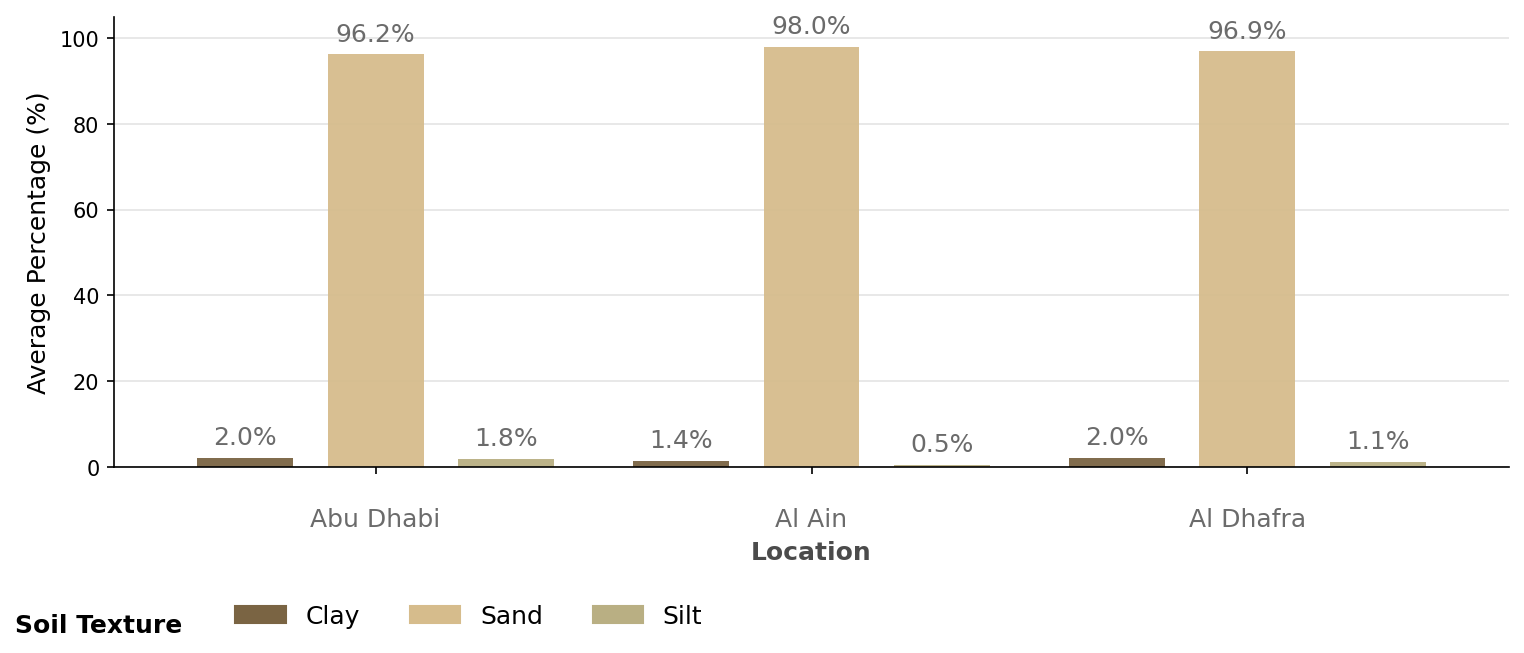

In [5]:
df_Physical = data_dict[year]["PHPhysical"].copy()
df_Physical = df_Physical[
    (df_Physical["PHUID"] == 1) &
    (df_Physical["PHSampleUID"] == 1) &
    (df_Physical["SurveyID"] == land_use_id)
]

ratio_df = compute_soil_texture_ratio(
    df_Physical,
    regions=regions
)

fig, ax = plot_soil_texture_grouped_bar(
    ratio_df,
    regions_order=regions,
    palette=SOIL_TEXTURE_PALETTE
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_soil_texture_grouped_bar.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_soil_texture_grouped_bar.svg"), bbox_inches="tight", pad_inches=0.1)


In [6]:
ratio_df = compute_soil_texture_ratio(
    df_Physical,
    regions='ALL'
)
ratio_df


,clay,sand,silt
A,NaN,NaN,NaN
L,NaN,NaN,NaN


# 1.2 Bulk Density

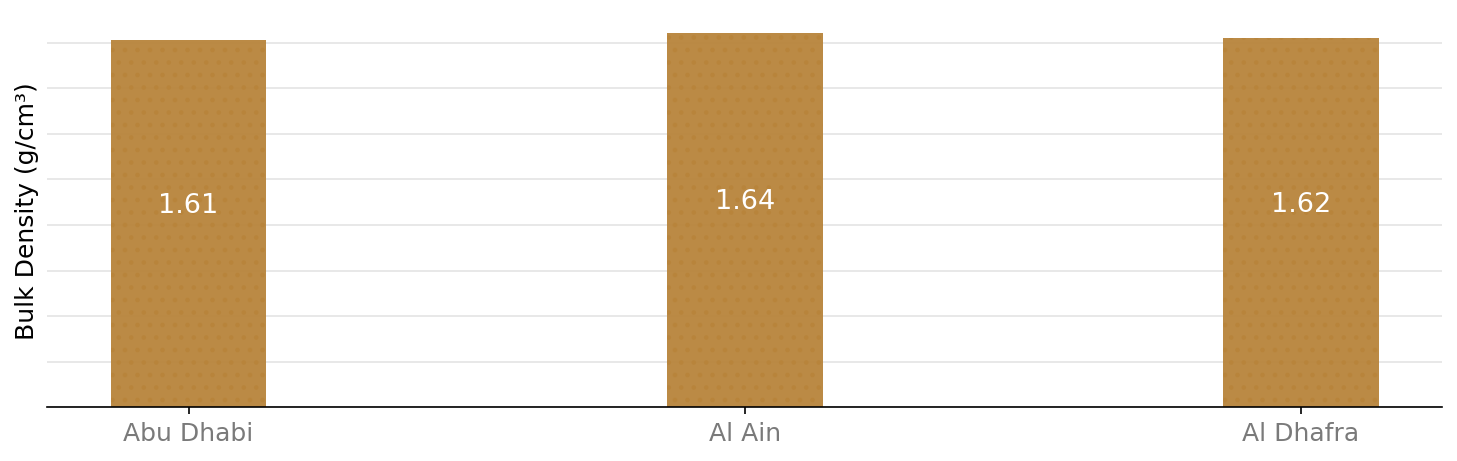

In [7]:
BULK_DENSITY_PALETTE = {
    "base": "#B8843B",
    "edge": "#B8843B",
    "value_text": "white",
}
bd_df = summary_bulk_density_by_region(
    df_Physical,
    regions=regions
)

fig, ax = plot_bulk_density_bar(
    bd_df,
    regions=regions,
    value_col="Bulk Density (g/cm³)",
    palette=BULK_DENSITY_PALETTE
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_bulk_density_bar.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_bulk_density_bar.svg"), bbox_inches="tight", pad_inches=0.1)

In [8]:
temp_df = df_Physical['BULKDENS']
print(f'mean {temp_df.mean().round(2)}, se {temp_df.std(ddof=1)/np.sqrt(len(temp_df))}, median {temp_df.median().round(2)}, min {temp_df.min().round(2)}, max {temp_df.max().round(2)}')

mean 1.63, se 0.011734981573064069, median 1.64, min 1.29, max 1.84


# 1.3 pH

#### 数据读取

In [9]:
col_name = "satph"
element_name = "pH"
df = get_table(data_dict, year, "PHChemical")
df = filter_surface_landuse_region(df, survey_id=land_use_id, regions=regions)
df

,SurveyID,SiteUID,SiteObsUID,PedonUID,PHUID,PHSampleUID,PHSubSampleUID,PHChemicalUID,Longitude,Latitude,...,satph,satec,TotalOrganicCarbon,TotalKjeldahlNitrogen_TKN,Boron \n(sat paste),Calcium \n(sat paste),Magnesium \n(sat paste),Sodium \n(sat paste),Potassium \n(sat paste),SAR
655,11,30043,1,2,1,1,1,1,52.422718,24.029025,...,7.6,6.210,0.140168,NaN,0.783,441.6989,57.2668,641.4565,187.419,7.619192
656,11,30011,1,2,1,1,1,1,51.726620,24.106118,...,7.6,3.740,0.040133,NaN,0.247,455.0748,35.8875,294.8900,39.202,3.576209
657,11,30039,1,2,1,1,1,1,51.841073,23.935299,...,7.0,198.000,1.121947,NaN,10.025,3068.1806,3623.2022,58133.9772,2761.896,168.214152
658,11,22406,2,2,1,1,1,1,52.094577,23.863842,...,7.0,133.000,0.535579,NaN,2.599,5195.9267,3076.3930,24379.3838,1328.906,66.187252
659,11,30038,1,2,1,1,1,1,52.136903,23.688493,...,7.5,10.700,0.050178,NaN,0.601,342.6204,72.9117,1766.5481,73.151,22.584880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,11,30042,1,2,1,1,1,1,54.959240,24.160123,...,8.0,0.342,0.06,NaN,0.108,34.4000,8.7000,20.3000,12.504,0.800000
739,11,30030,1,2,1,1,1,1,54.714660,23.887750,...,8.1,0.489,0.11,NaN,0.094,32.2000,13.4000,37.3000,11.568,1.400000
740,11,22431,2,2,1,1,1,1,54.708353,23.649898,...,7.6,1.310,0.100027,NaN,0.132,182.0000,25.6000,56.5000,15.507,1.040000
741,11,30034,1,2,1,1,1,1,54.697735,24.729132,...,7.4,40.900,0.146146,NaN,2.693,1360.0000,682.0000,8220.0000,292.586,45.400000


In [10]:
temp_df = df[col_name]
print(f'mean {temp_df.mean().round(2)}, se {temp_df.std(ddof=1)/np.sqrt(len(temp_df))}, median {temp_df.median().round(2)}, min {temp_df.min().round(2)}, max {temp_df.max().round(2)}')

mean 7.72, se 0.040020132883095944, median 7.8, min 6.57, max 8.3


#### 极值点坐标

In [11]:
extreme_ph = get_extreme_point(
    df,
    value_col=col_name,
    mode="min",   # pH 取最小
)

extreme_ph

Region       Abu Dhabi
SiteUID          10010
Longitude    54.581213
Latitude      24.17845
Value             6.57
dtype: object

#### 描述性统计

In [12]:
df_surface = summary_by_region(df, value_col=col_name, regions=regions, landuse_name=land_use_name)
display(df_surface)

Mean ± se  Median   Min  Max   n
LandUse       Region                                       
Non-developed Abu Dhabi  7.51 ± 0.13    7.55  6.57  8.2  16
              Al Ain     7.79 ± 0.07    7.90  6.90  8.2  20
              Al Dhafra  7.76 ± 0.04    7.80  7.00  8.3  48

#### 显著性检验

In [13]:
samples = regional_samples(df, value_col=col_name, regions=regions)
df_post, sig_dict, all_normal = posthoc_tests(samples, regions)
display(df_post)

letters = assign_letters_from_sig(df_surface.reset_index(), sig_dict, landuse_name=land_use_name, regions=regions)
df_ph_surface_labeled = append_letters_to_summary(df_surface, letters, landuse_name=land_use_name, regions=regions)
display(df_ph_surface_labeled)

,Comparison,Test,p_raw,p_adj_holm,Significant
0,Abu Dhabi vs Al Ain,Mann–Whitney U,0.113277,0.339832,False
1,Abu Dhabi vs Al Dhafra,Mann–Whitney U,0.144824,0.339832,False
2,Al Ain vs Al Dhafra,Mann–Whitney U,0.438469,0.438469,False


Mean ± se  Median   Min  Max   n
LandUse       Region                                         
Non-developed Abu Dhabi  7.51 ± 0.13 a    7.55  6.57  8.2  16
              Al Ain     7.79 ± 0.07 a    7.90  6.90  8.2  20
              Al Dhafra  7.76 ± 0.04 a    7.80  7.00  8.3  48

#### 分级表 + 堆叠图

Percentage (%)  Count
Region    Class                                               
Abu Dhabi Strongly Acidic (<5.6)                    0.0      0
          Moderately Acidic (5.6–6.0)               0.0      0
          Slightly Acidic (6.1–6.5)                 6.2      1
          Neutral (6.6–7.3)                        25.0      4
          Slightly Alkaline (7.4–7.8)              37.5      6
          Moderately Alkaline (7.9–8.4)            31.2      5
          Strongly Alkaline (8.5–9.0)               0.0      0
          Extremely Alkaline (>9.0)                 0.0      0
Al Ain    Strongly Acidic (<5.6)                    0.0      0
          Moderately Acidic (5.6–6.0)               0.0      0
          Slightly Acidic (6.1–6.5)                 0.0      0
          Neutral (6.6–7.3)                        10.0      2
          Slightly Alkaline (7.4–7.8)              35.0      7
          Moderately Alkaline (7.9–8.4)            55.0     11
          Strongly Alkaline (8.5–9.0)               0.0      0
          Extremely Alkaline (>9.0)                 0.0      0
Al Dhafra Strongly Acidic (<5.6)                    0.0      0
          Moderately Acidic (5.6–6.0)               0.0      0
          Slightly Acidic (6.1–6.5)                 0.0      0
          Neutral (6.6–7.3)                        10.4      5
          Slightly Alkaline (7.4–7.8)              47.9     23
          Moderately Alkaline (7.9–8.4)            41.7     20
          Strongly Alkaline (8.5–9.0)               0.0      0
          Extremely Alkaline (>9.0)                 0.0      0

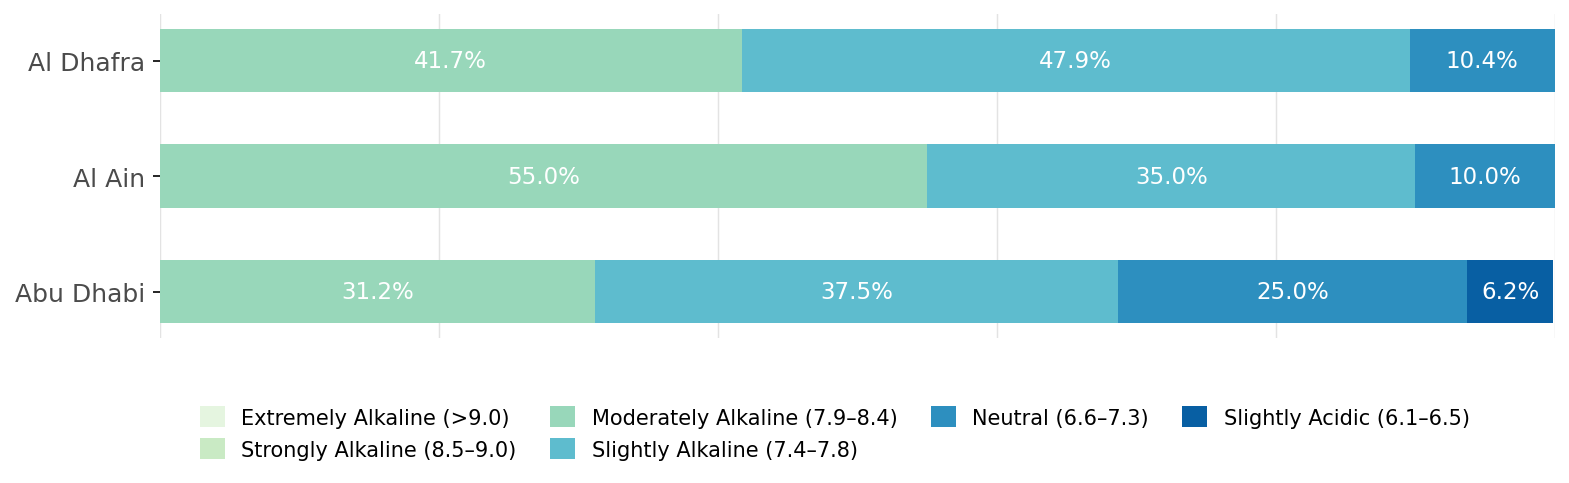

In [14]:
bins = [
    (-float("inf"), 5.6,  "Strongly Acidic (<5.6)"),
    (5.6, 6.09,       "Moderately Acidic (5.6–6.0)"),
    (6.1, 6.59,       "Slightly Acidic (6.1–6.5)"),
    (6.6, 7.39,       "Neutral (6.6–7.3)"),
    (7.4, 7.89,       "Slightly Alkaline (7.4–7.8)"),
    (7.9, 8.49,       "Moderately Alkaline (7.9–8.4)"),
    (8.5, 9.0,       "Strongly Alkaline (8.5–9.0)"),
    (9.0, float("inf"), "Extremely Alkaline (>9.0)"),
]

df_ph_class = class_distribution_by_region(df, value_col=col_name, bins=bins, regions=regions)
display(df_ph_class)
class_order = [
    "Extremely Alkaline (>9.0)",
    "Strongly Alkaline (8.5–9.0)",
    "Moderately Alkaline (7.9–8.4)",
    "Slightly Alkaline (7.4–7.8)",
    "Neutral (6.6–7.3)",
    "Slightly Acidic (6.1–6.5)",
]

cmap_name = "GnBu"
cmap = plt.get_cmap(cmap_name)
n = len(class_order)
values = np.linspace(0.1, 0.9, n)  # 避开两端极端色
hex_colors = [to_hex(cmap(v)) for v in values]
colors = dict(zip(class_order, hex_colors))

fig, ax = plot_stacked_percent_barh(
    df_ph_class,
    regions_order=regions,
    class_order=class_order,
    colors=colors,
    label_min=3.0,
    legend_ncol=4
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_stacked_percent_barh.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_stacked_percent_barh.svg"), bbox_inches="tight", pad_inches=0.1)

#### 箱线图 + 散点 + 均值

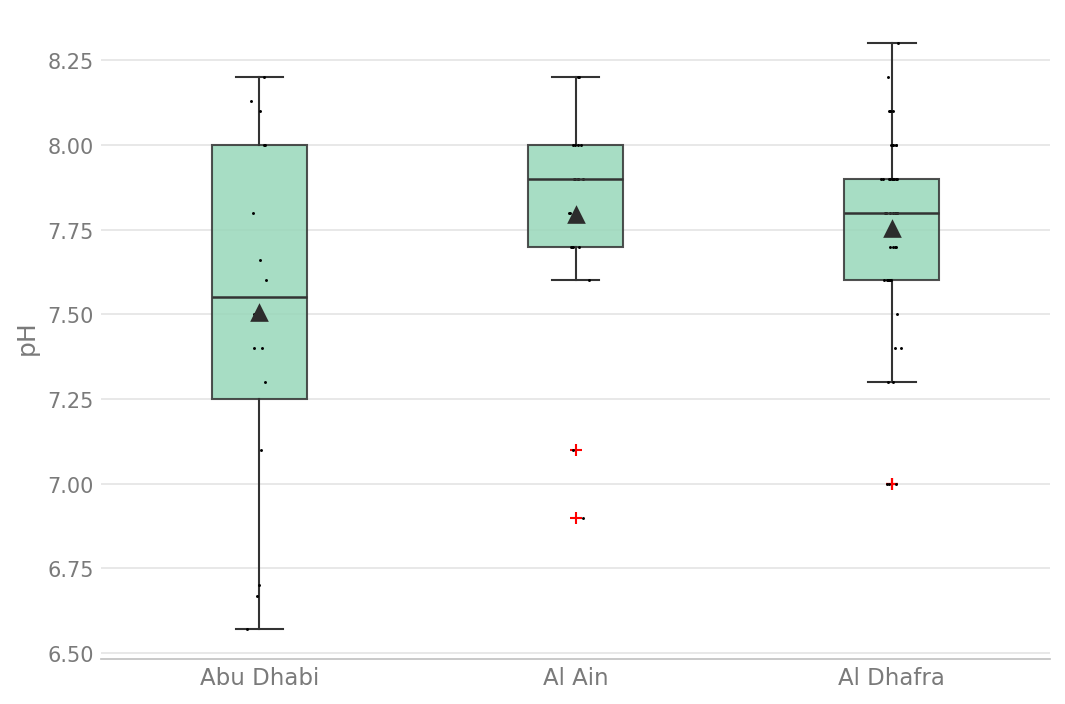

In [15]:
fig, ax = plot_box_jitter_mean(
    df, value_col=col_name,
    regions_order=regions,
    ylabel=element_name,
    exclude_below=None,
    facecolor=hex_colors[2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_box_jitter_mean.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_box_jitter_mean.svg"), bbox_inches="tight", pad_inches=0.1)

#### 单年均值柱形图

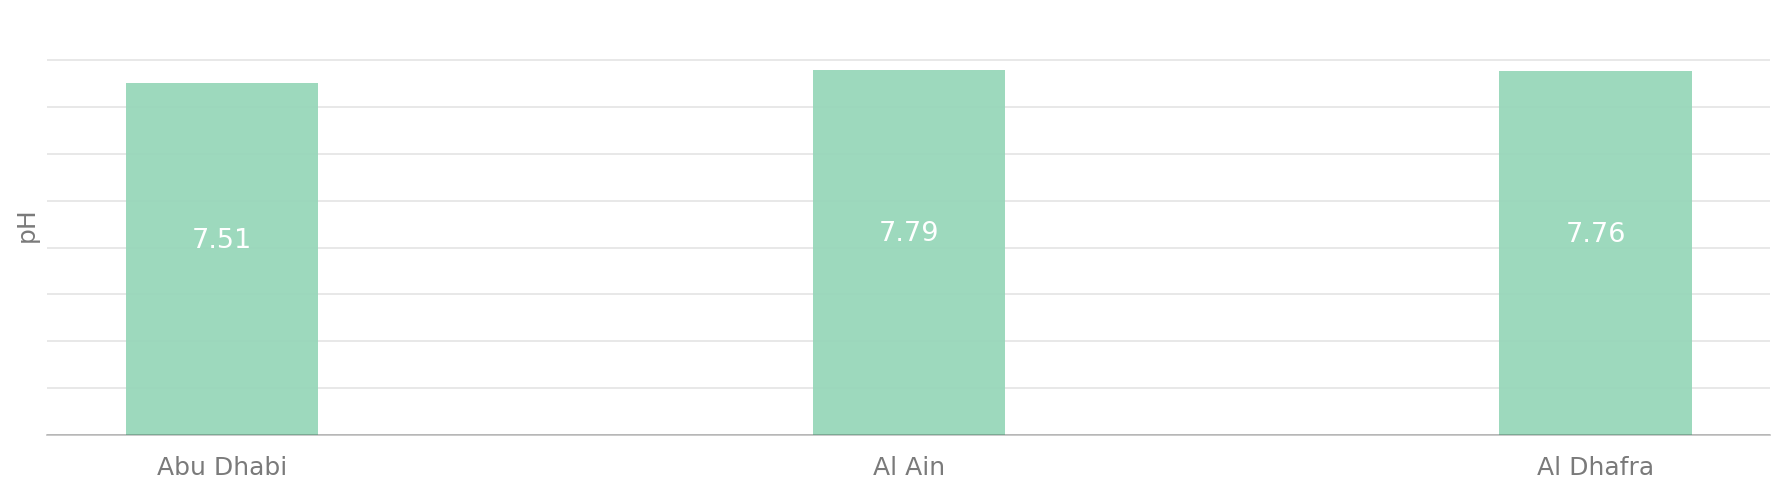

In [16]:
PH_PALETTE = {
    "base": hex_colors[2],
    "edge": "#C79A78",
    "mean": "#2C2C2C",
    "scatter": "#000000",
    "value_text": "white",
}

fig, ax = plot_mean_bar_single_year(
    df_surface,                       # 你前面算出来的 summary 表
    regions=regions,
    landuse_name=land_use_name,
    palette=PH_PALETTE,
    ylabel=element_name,
    legend_label="Surface",
    legend=False,
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_mean_bar_single_year.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_mean_bar_single_year.svg"), bbox_inches="tight", pad_inches=0.1)

#### 2020–2025 年度趋势

C:\Users\blkmo\.conda\envs\myenv\Lib\site-packages\statsmodels\stats\weightstats.py:981: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(d1._var / (d1.nobs - 1) + d2._var / (d2.nobs - 1))
C:\Users\blkmo\.conda\envs\myenv\Lib\site-packages\statsmodels\stats\weightstats.py:1008: RuntimeWarning: invalid value encountered in scalar divide
  sem1 = d1._var / (d1.nobs - 1)


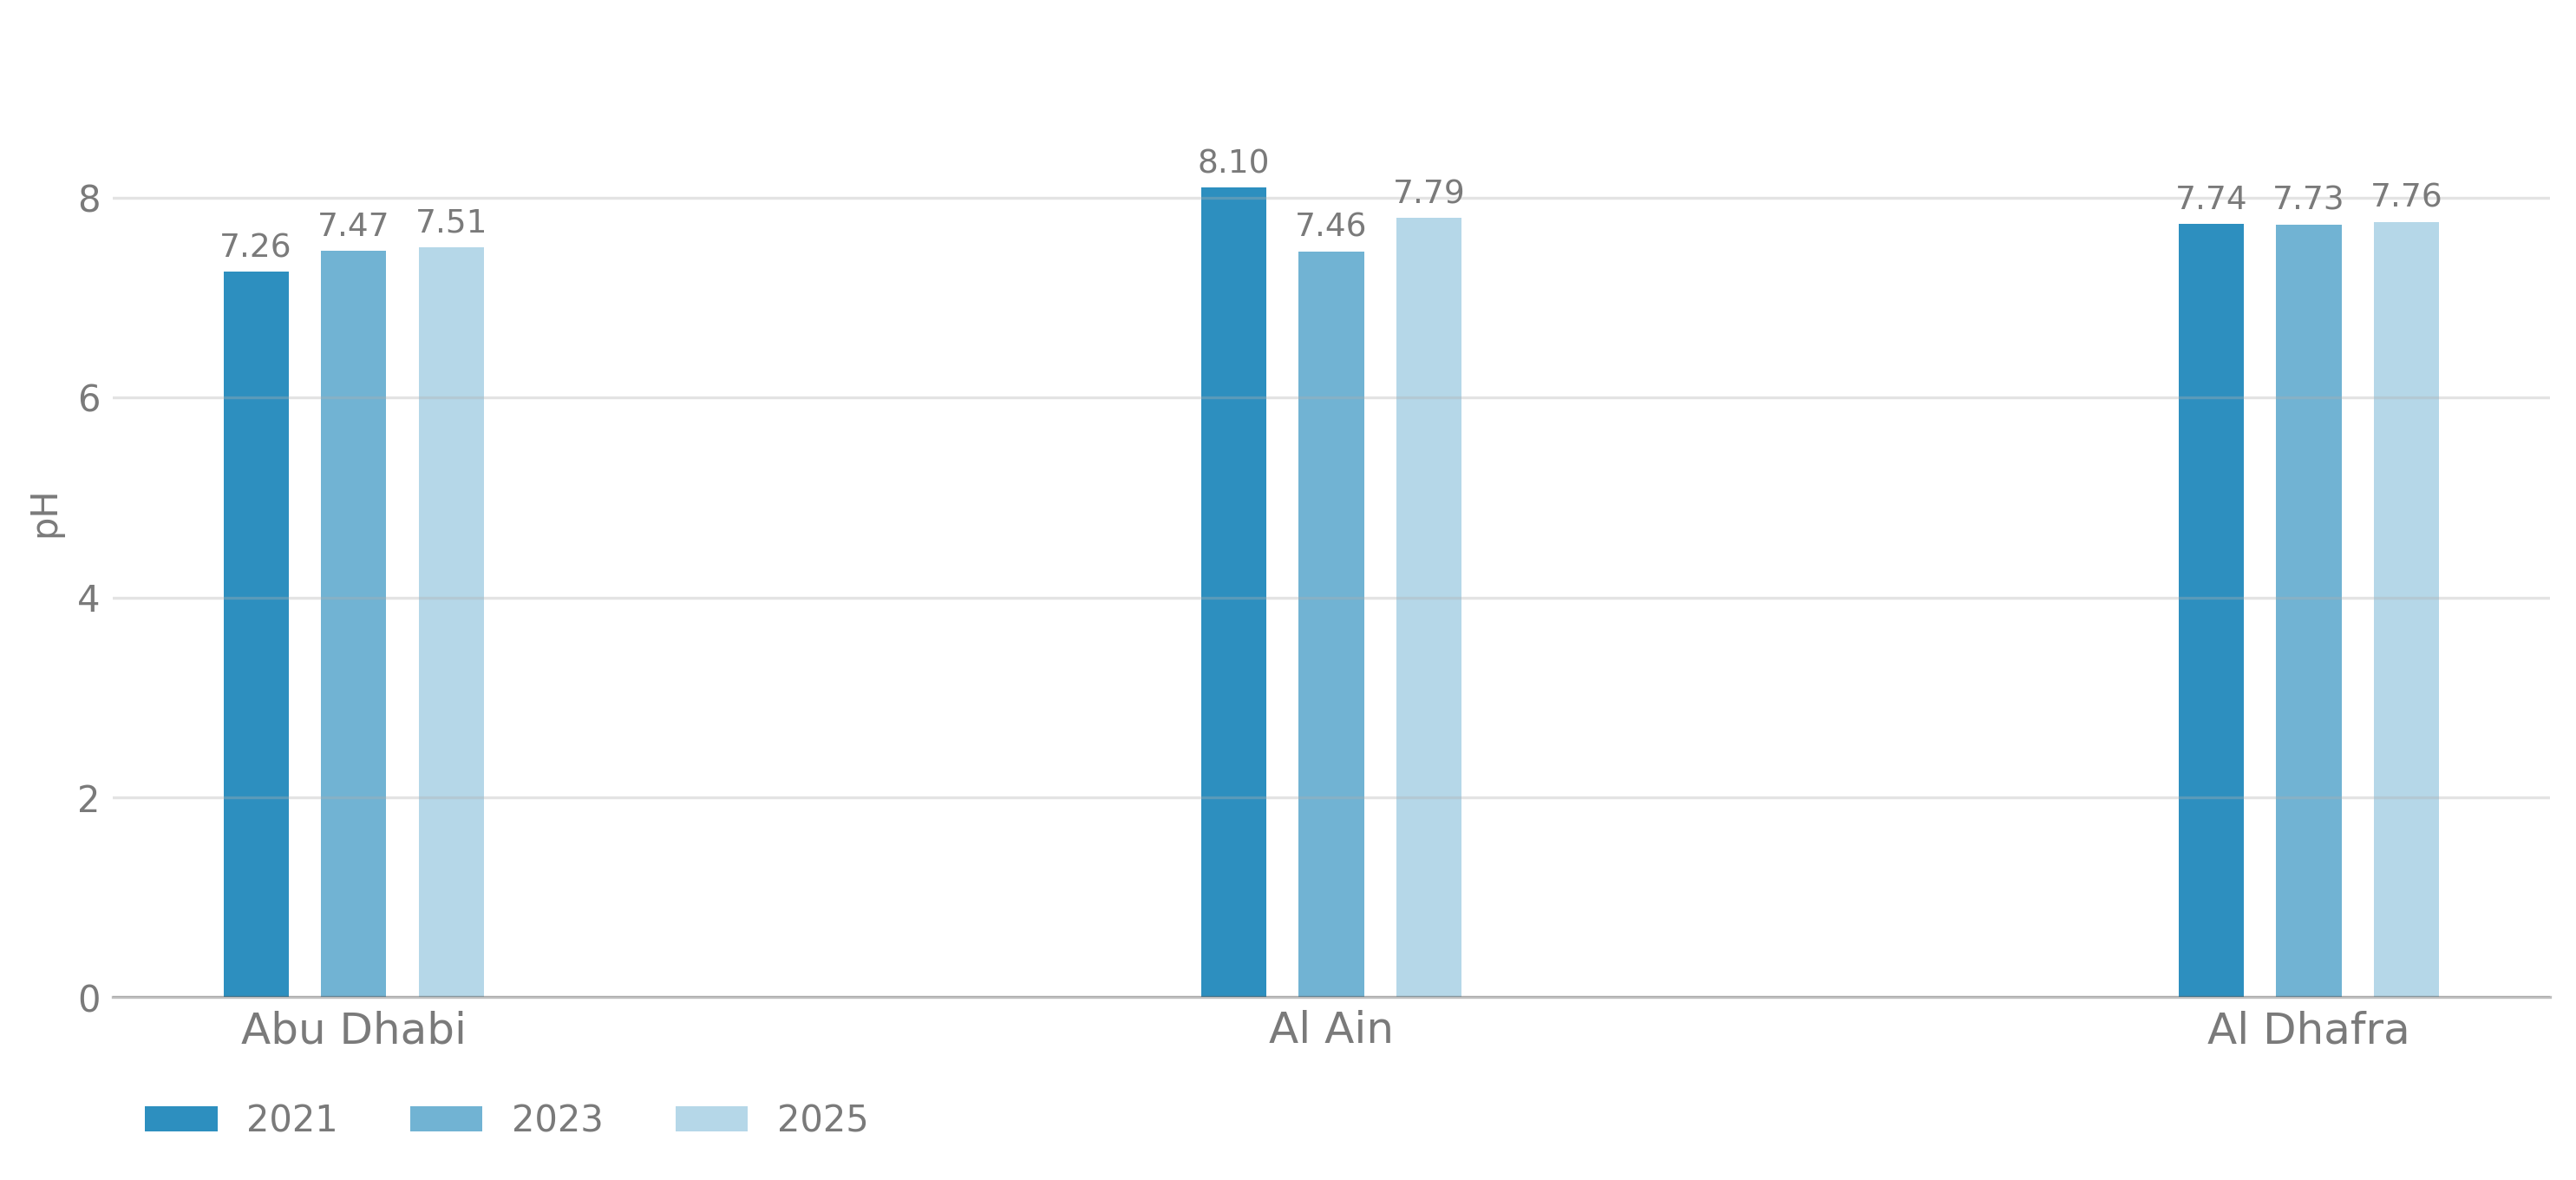

In [17]:
years = [f"Soil quality data {y}" for y in range(2020, 2026)]

ph_long = build_long_year_region(
    data_dict,
    years=years,
    table="PHChemical",
    value_col=col_name,
    survey_id=land_use_id,
    regions=regions,
)

anova_by_region, posthoc_by_region = year_anova_posthoc_by_region(ph_long)
adj_star = adjacent_sig_years_from_posthoc(ph_long, posthoc_by_region)

mean_by_region_year = (
    ph_long.groupby(["Region", "YearNum"], as_index=False)["Value"]
           .mean()
           .rename(columns={"Value": "MeanValue"})
)

fig, ax = plot_grouped_bars_years(
    mean_by_region_year,
    regions_order=regions,
    star_years=adj_star,
    ylabel=element_name,
    base_color=hex_colors[-2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_grouped_bars_years.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_grouped_bars_years.svg"), bbox_inches="tight", pad_inches=0.1)

# 1.4 Electrical Conductivity (ECe)

#### 数据读取

In [18]:
col_name = "satec"
element_name = "ECe"
df = get_table(data_dict, year, "PHChemical")
df = filter_surface_landuse_region(df, survey_id=land_use_id, regions=regions)
df

,SurveyID,SiteUID,SiteObsUID,PedonUID,PHUID,PHSampleUID,PHSubSampleUID,PHChemicalUID,Longitude,Latitude,...,satph,satec,TotalOrganicCarbon,TotalKjeldahlNitrogen_TKN,Boron \n(sat paste),Calcium \n(sat paste),Magnesium \n(sat paste),Sodium \n(sat paste),Potassium \n(sat paste),SAR
655,11,30043,1,2,1,1,1,1,52.422718,24.029025,...,7.6,6.210,0.140168,NaN,0.783,441.6989,57.2668,641.4565,187.419,7.619192
656,11,30011,1,2,1,1,1,1,51.726620,24.106118,...,7.6,3.740,0.040133,NaN,0.247,455.0748,35.8875,294.8900,39.202,3.576209
657,11,30039,1,2,1,1,1,1,51.841073,23.935299,...,7.0,198.000,1.121947,NaN,10.025,3068.1806,3623.2022,58133.9772,2761.896,168.214152
658,11,22406,2,2,1,1,1,1,52.094577,23.863842,...,7.0,133.000,0.535579,NaN,2.599,5195.9267,3076.3930,24379.3838,1328.906,66.187252
659,11,30038,1,2,1,1,1,1,52.136903,23.688493,...,7.5,10.700,0.050178,NaN,0.601,342.6204,72.9117,1766.5481,73.151,22.584880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,11,30042,1,2,1,1,1,1,54.959240,24.160123,...,8.0,0.342,0.06,NaN,0.108,34.4000,8.7000,20.3000,12.504,0.800000
739,11,30030,1,2,1,1,1,1,54.714660,23.887750,...,8.1,0.489,0.11,NaN,0.094,32.2000,13.4000,37.3000,11.568,1.400000
740,11,22431,2,2,1,1,1,1,54.708353,23.649898,...,7.6,1.310,0.100027,NaN,0.132,182.0000,25.6000,56.5000,15.507,1.040000
741,11,30034,1,2,1,1,1,1,54.697735,24.729132,...,7.4,40.900,0.146146,NaN,2.693,1360.0000,682.0000,8220.0000,292.586,45.400000


In [19]:
temp_df = df[col_name]
print(f'mean {temp_df.mean().round(2)}, se {temp_df.std(ddof=1)/np.sqrt(len(temp_df))}, median {temp_df.median().round(2)}, min {temp_df.min().round(2)}, max {temp_df.max().round(2)}')

mean 27.57, se 6.647348619072409, median 1.3, min 0.24, max 219.0


#### 极值点坐标

In [20]:
extreme_ph = get_extreme_point(
    df,
    value_col=col_name,
    mode="max",  # pH 取最小
)

extreme_ph

Region       Abu Dhabi
SiteUID          10010
Longitude    54.581213
Latitude      24.17845
Value            219.0
dtype: object

#### 描述性统计

In [21]:
df_surface = summary_by_region(df, value_col=col_name, regions=regions, landuse_name=land_use_name)
display(df_surface)

Mean ± se  Median   Min    Max   n
LandUse       Region                                           
Non-developed Abu Dhabi  59.01 ± 20.46    5.84  0.34  219.0  16
              Al Ain     18.20 ± 11.33    1.10  0.28  181.0  20
              Al Dhafra   21.00 ± 7.86    1.05  0.24  212.0  48

#### 显著性检验

In [22]:
samples = regional_samples(df, value_col=col_name, regions=regions)
df_post, sig_dict, all_normal = posthoc_tests(samples, regions)
display(df_post)

letters = assign_letters_from_sig(df_surface.reset_index(), sig_dict, landuse_name=land_use_name, regions=regions)
df_ph_surface_labeled = append_letters_to_summary(df_surface, letters, landuse_name=land_use_name, regions=regions)
display(df_ph_surface_labeled)

,Comparison,Test,p_raw,p_adj_holm,Significant
1,Abu Dhabi vs Al Dhafra,Mann–Whitney U,0.017317,0.051950,False
0,Abu Dhabi vs Al Ain,Mann–Whitney U,0.040033,0.080067,False
2,Al Ain vs Al Dhafra,Mann–Whitney U,0.792966,0.792966,False


Mean ± se  Median   Min    Max   n
LandUse       Region                                             
Non-developed Abu Dhabi  59.01 ± 20.46 a    5.84  0.34  219.0  16
              Al Ain     18.20 ± 11.33 a    1.10  0.28  181.0  20
              Al Dhafra   21.00 ± 7.86 a    1.05  0.24  212.0  48

#### 分级表 + 堆叠图

Percentage (%)  Count
Region    Class                                                 
Abu Dhabi Non-Saline (<2 dS/m)                       31.2      5
          Very Slightly Saline (2–4 dS/m)            18.8      3
          Slightly Saline (4–8 dS/m)                  0.0      0
          Moderately Saline (8–16 dS/m)               6.2      1
          Very Strongly Saline (>16 dS/m)            43.8      7
Al Ain    Non-Saline (<2 dS/m)                       55.0     11
          Very Slightly Saline (2–4 dS/m)            25.0      5
          Slightly Saline (4–8 dS/m)                 10.0      2
          Moderately Saline (8–16 dS/m)               0.0      0
          Very Strongly Saline (>16 dS/m)            10.0      2
Al Dhafra Non-Saline (<2 dS/m)                       60.4     29
          Very Slightly Saline (2–4 dS/m)            16.7      8
          Slightly Saline (4–8 dS/m)                  4.2      2
          Moderately Saline (8–16 dS/m)               6.2      3
          Very Strongly Saline (>16 dS/m)            12.5      6

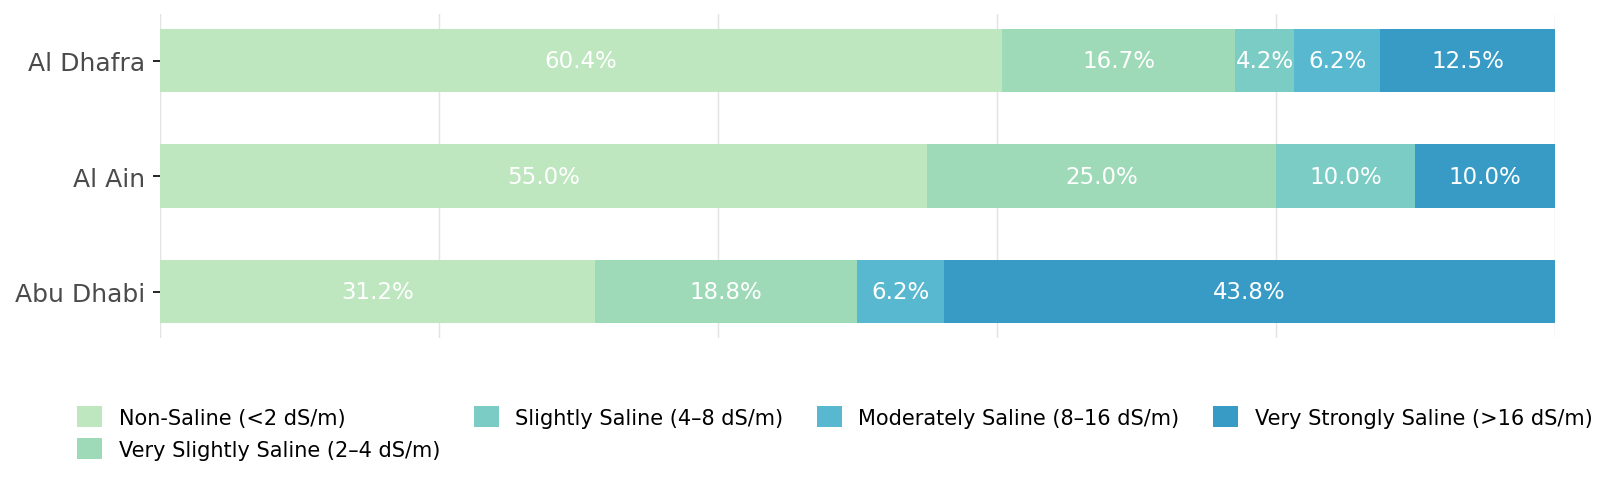

In [23]:
bins = [
    (-float("inf"), 2.0,    "Non-Saline (<2 dS/m)"),
    (2.0, 4.0,             "Very Slightly Saline (2–4 dS/m)"),
    (4.0, 8.0,             "Slightly Saline (4–8 dS/m)"),
    (8.0, 16.0,            "Moderately Saline (8–16 dS/m)"),
    (16.0, float("inf"),   "Very Strongly Saline (>16 dS/m)"),
]

df_ph_class = class_distribution_by_region(df, value_col=col_name, bins=bins, regions=regions, right_inclusive= False)
display(df_ph_class)
class_order = [
    "Non-Saline (<2 dS/m)",
    "Very Slightly Saline (2–4 dS/m)",
    "Slightly Saline (4–8 dS/m)",
    "Moderately Saline (8–16 dS/m)",
    "Very Strongly Saline (>16 dS/m)",
]

cmap_name = "GnBu"
cmap = plt.get_cmap(cmap_name)
n = len(class_order)
values = np.linspace(0.3, 0.7, n)  # 避开两端极端色
hex_colors = [to_hex(cmap(v)) for v in values]
colors = dict(zip(class_order, hex_colors))

fig, ax = plot_stacked_percent_barh(
    df_ph_class,
    regions_order=regions,
    class_order=class_order,
    colors=colors,
    label_min=3.0,
    legend_ncol=4
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_stacked_percent_barh.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_stacked_percent_barh.svg"), bbox_inches="tight", pad_inches=0.1)

#### 箱线图 + 散点 + 均值

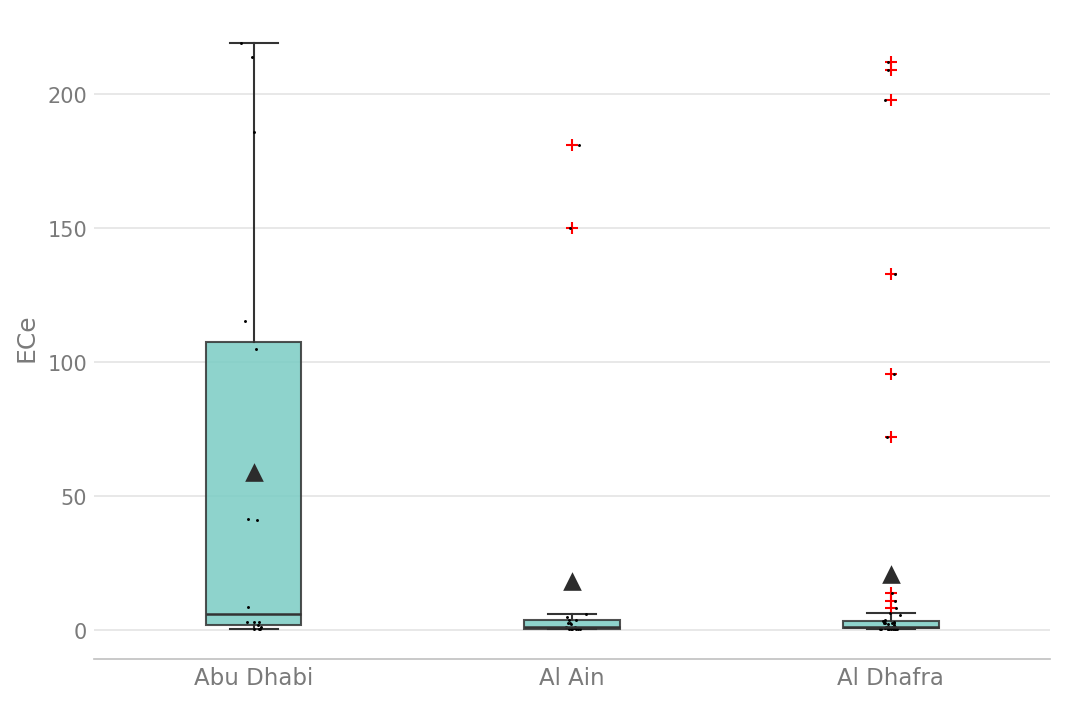

In [24]:
fig, ax = plot_box_jitter_mean(
    df, value_col=col_name,
    regions_order=regions,
    ylabel=element_name,
    exclude_below=None,
    facecolor=hex_colors[2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_box_jitter_mean.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_box_jitter_mean.svg"), bbox_inches="tight", pad_inches=0.1)

#### 单年均值柱形图

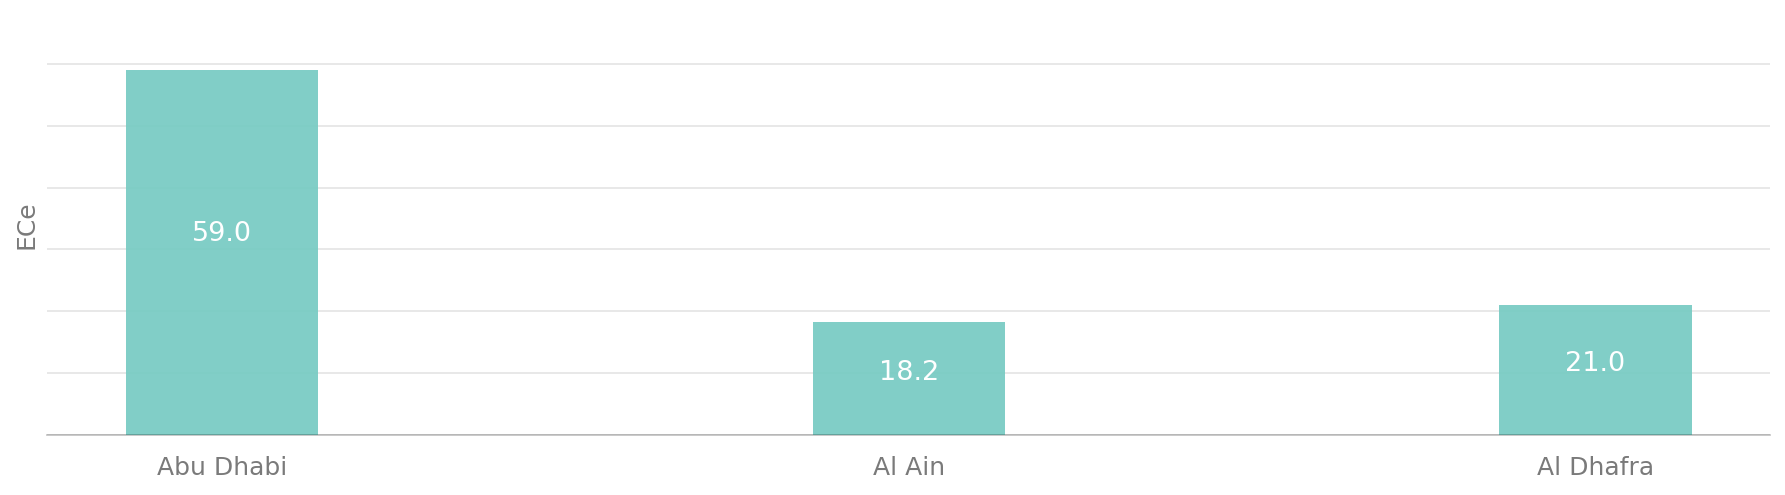

In [25]:
PH_PALETTE = {
    "base": hex_colors[2],
    "edge": "#C79A78",
    "mean": "#2C2C2C",
    "scatter": "#000000",
    "value_text": "white",
}

fig, ax = plot_mean_bar_single_year(
    df_surface,                       # 你前面算出来的 summary 表
    regions=regions,
    landuse_name=land_use_name,
    palette=PH_PALETTE,
    ylabel=element_name,
    legend=False,
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_mean_bar_single_year.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_mean_bar_single_year.svg"), bbox_inches="tight", pad_inches=0.1)

#### 2020–2025 年度趋势

C:\Users\blkmo\.conda\envs\myenv\Lib\site-packages\statsmodels\stats\weightstats.py:981: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(d1._var / (d1.nobs - 1) + d2._var / (d2.nobs - 1))
C:\Users\blkmo\.conda\envs\myenv\Lib\site-packages\statsmodels\stats\weightstats.py:1008: RuntimeWarning: invalid value encountered in scalar divide
  sem1 = d1._var / (d1.nobs - 1)


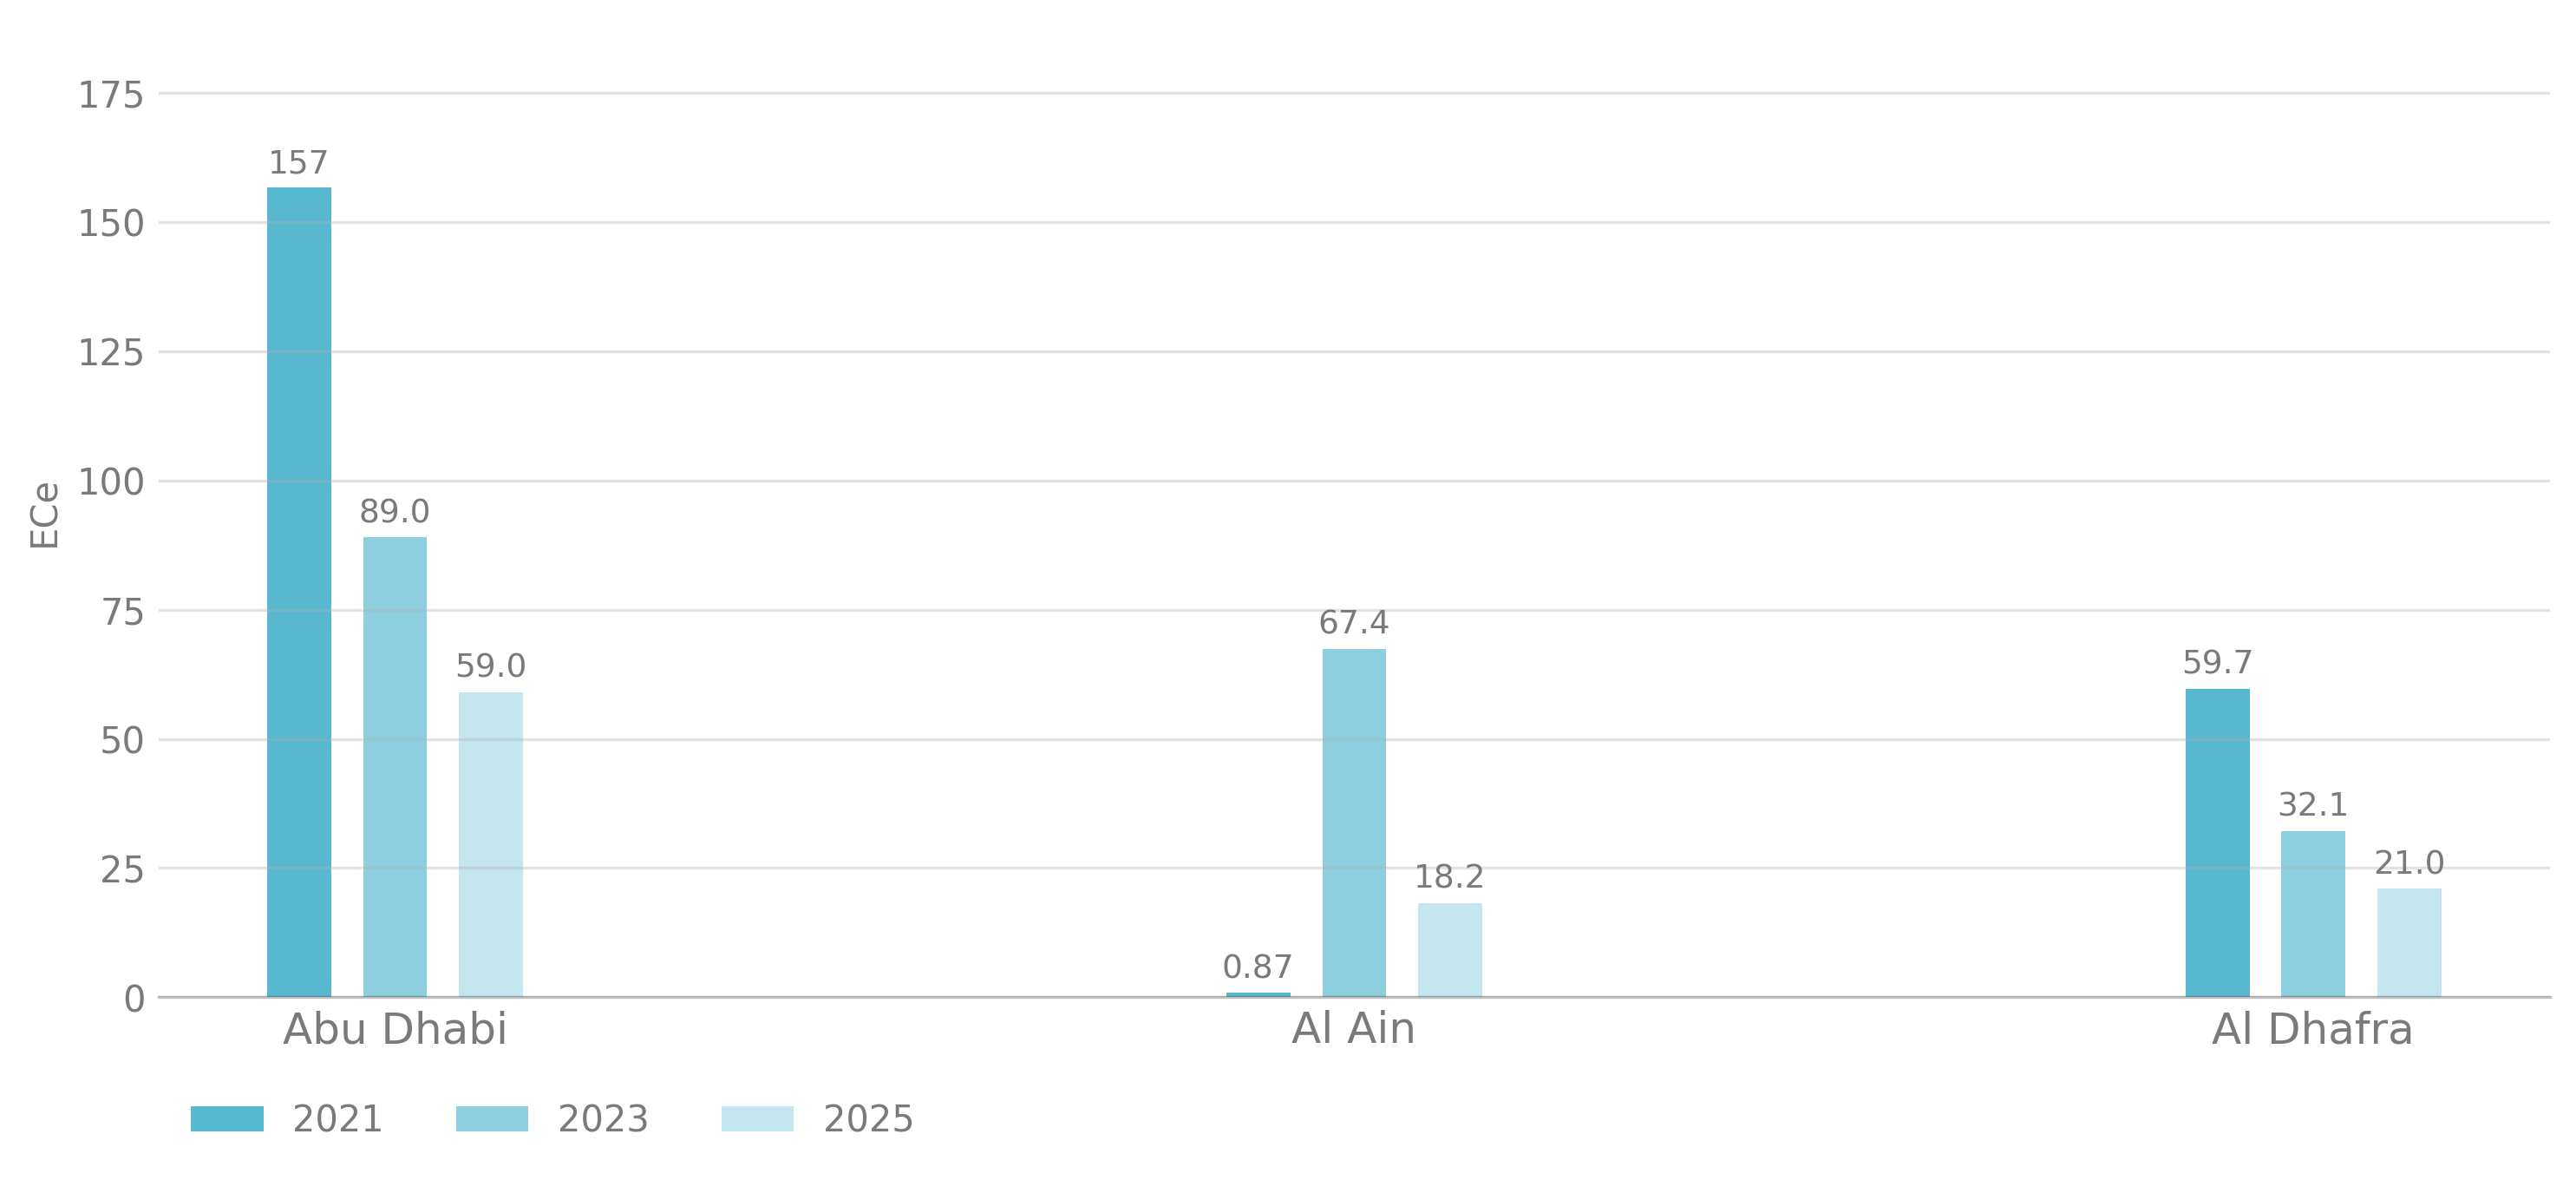

In [26]:
years = [f"Soil quality data {y}" for y in range(2020, 2026)]

ph_long = build_long_year_region(
    data_dict,
    years=years,
    table="PHChemical",
    value_col=col_name,
    survey_id=land_use_id,
    regions=regions,
)

anova_by_region, posthoc_by_region = year_anova_posthoc_by_region(ph_long)
adj_star = adjacent_sig_years_from_posthoc(ph_long, posthoc_by_region)

mean_by_region_year = (
    ph_long.groupby(["Region", "YearNum"], as_index=False)["Value"]
           .mean()
           .rename(columns={"Value": "MeanValue"})
)

fig, ax = plot_grouped_bars_years(
    mean_by_region_year,
    regions_order=regions,
    star_years=adj_star,
    ylabel=element_name,
    base_color=hex_colors[-2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_grouped_bars_years.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_{element_name}_grouped_bars_years.svg"), bbox_inches="tight", pad_inches=0.1)

# 2 Inorganic Parameters - Heavy Metals

In [27]:
element_dict = {
    "Arsenic": "Arsenic",
    "Beryllium": "Beryllium",
    "Cadmium": "Cadmium",
    "Cobalt": "Cobalt",
    "Chromium Total": "Chromium_Total",
    "Copper": "Copper",
    "Lead": "Lead_aqua",
    "Molybdenum": "Molybdenum",
    "Nickel": "Nickel_aqua",
    "Selenium": "Selenium_aqua",
    "Vanadium": "Vanadium",
    "Zinc": "Zinc",
    "Mercury": "InorganicMercury",
}

Threshold_dict = {
    "Arsenic": 18,
    "Beryllium": 10,
    "Cadmium": 0.36,
    "Cobalt": 13,
    "Chromium Total": 28.8,
    "Copper": 49,
    "Lead": 56,
    "Molybdenum": 2,
    "Nickel": 57,
    "Selenium": 0.52,
    "Vanadium": 13.8,
    "Zinc": 79,
    "Mercury": 0.3,
}

df = pd.read_excel(
    '../Result_hmq/Soil quality data QC/Soil quality data QC 2025.xlsx',
    sheet_name='Processed_Data'
)

df = df[
    (df["PHUID"] == 1) &
    (df["PHSampleUID"] == 1) &
    (df["SurveyID"] == land_use_id)
]

rows = []

for element, col in element_dict.items():

    # ---------- 跳过不存在的字段 ----------
    if col not in df.columns:
        continue

    sub = pd.to_numeric(df[col], errors="coerce").dropna()
    n = sub.size

    rows.append({
        "Element": element,
        "Mean": sub.mean(),
        "SE": sub.std(ddof=1) / np.sqrt(n) if n > 1 else np.nan,
        "Median": sub.median(),
        "Min": sub.min(),
        "Max": sub.max(),
        "N": n,
    })

summary_table = pd.DataFrame(rows)
summary_table

,Element,Mean,SE,Median,Min,Max,N
0,Arsenic,1.511751,0.047736,1.396625,0.503283,3.035342,83
1,Beryllium,0.098495,0.005230,0.103876,0.037500,0.244808,84
2,Cadmium,0.070365,0.003567,0.072921,0.025000,0.155694,83
3,Cobalt,2.402064,0.129147,2.101341,1.545800,11.629586,84
4,Chromium Total,15.628312,0.925248,13.822928,8.023494,80.937470,84
5,Copper,3.469806,0.076897,3.314319,2.548982,6.465673,84
6,Lead,1.651582,0.038675,1.628987,0.591097,2.582912,84
7,Molybdenum,0.399561,0.029833,0.302679,0.146576,1.722940,84
8,Nickel,20.867206,2.647432,14.286692,8.441194,200.571277,84
9,Selenium,0.161022,0.011126,0.145069,0.000000,0.626180,84


In [28]:
rows_exceed = []

for element, col in element_dict.items():

    if col not in df.columns:
        continue

    sub = pd.to_numeric(df[col], errors="coerce").dropna()
    n = sub.size
    if n == 0:
        continue

    threshold = Threshold_dict[element]
    exceed_rate = (sub > threshold).mean()  # 比例（0–1）

    rows_exceed.append({
        "Element": element,
        "Exceedance Rate": exceed_rate,
        "N": n,
        "Threshold": threshold,
    })

exceed_table = pd.DataFrame(rows_exceed)

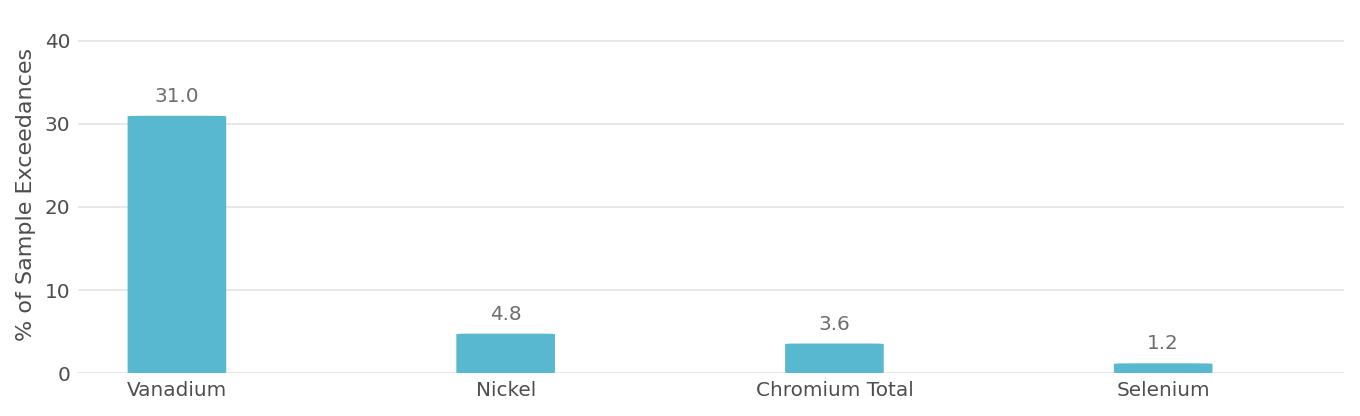

In [29]:
from matplotlib.patches import FancyBboxPatch
# 基于你上一步得到的 exceed_table
plot_df = exceed_table.sort_values("Exceedance Rate", ascending=False).copy()
plot_df["pct"] = plot_df["Exceedance Rate"] * 100
plot_df = plot_df[plot_df["pct"]!=0]

# ========= 画布与轴 =========
fig, ax = plt.subplots(figsize=(8.6, 2.7), dpi=160)


bar_w = 0.3  # 柱宽（参考图柱子较“粗”）
rounding = 0.18  # 圆角强度（相对柱宽的观感）
x = np.arange(len(plot_df)) + bar_w

# ========= 网格与边框（参考图风格） =========
ax.set_axisbelow(True)
ax.yaxis.grid(True, color="#E6E6E6", linewidth=0.8)
ax.xaxis.grid(False)

# 只保留左/下边框或全去掉（参考图偏“干净”）
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_color("#BDBDBD")
ax.spines["bottom"].set_color("#BDBDBD")

# ========= 圆角柱（用 FancyBboxPatch） =========
# 颜色建议：一个偏绿灰，一个偏蓝灰（参考图类似），你也可自行改
bar_color = hex_colors[-2]  # muted green
edge_color = "none"

for i, v in enumerate(plot_df["pct"].to_numpy()):
    left = x[i] - bar_w / 2
    patch = FancyBboxPatch(
        (left, 0), bar_w, float(v),
        boxstyle=f"round,pad=0,rounding_size={bar_w * rounding}",
        linewidth=0,
        facecolor=bar_color,
        edgecolor=edge_color,
        mutation_aspect=1
    )
    ax.add_patch(patch)

    # 顶部数值标注（参考图是柱顶上方、浅灰）
    ax.text(
        x[i], v + 1.2, f"{v:.1f}",
        ha="center", va="bottom",
        fontsize=9, color="#6E6E6E"
    )

# ========= 轴标签/标题 =========
ax.set_ylabel("% of Sample Exceedances", fontsize=10, color="#4D4D4D")

ax.set_xticks(x)
ax.set_xticklabels(plot_df["Element"], fontsize=9, color="#4D4D4D")

ax.set_ylim(0, min(100, max(10, plot_df["pct"].max() + 12)))
ax.set_xlim(0, len(plot_df) - bar_w / 2)
ax.tick_params(axis="y", length=0, labelsize=9, colors="#4D4D4D")
ax.tick_params(axis="x", length=0)
for s in ["top", "right", "left", "bottom"]:
    ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch10_MetalExceedScreeningLevels.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_MetalExceedScreeningLevels.svg"), bbox_inches="tight", pad_inches=0.1)

In [30]:
def plot_elements_box(elements, title, color, scale='nomral'):
    if not elements:
        print(f"[INFO] {title}: empty group")
        return

    data_by_element = [data_map[e] for e in elements]

    fig, ax = plt.subplots(figsize=(10.5, 4.2), dpi=150)
    facecolor = color

    ax.boxplot(
        data_by_element,
        widths=0.38,
        patch_artist=True,
        showfliers=True,
        flierprops=dict(marker="+", markersize=6, markerfacecolor="none",
                        markeredgecolor="red", markeredgewidth=1.0, linestyle="none"),
        boxprops=dict(facecolor=facecolor, edgecolor="#333333", linewidth=1.0, alpha=0.85),
        medianprops=dict(color="#333333", linewidth=1.2),
        whiskerprops=dict(color="#333333", linewidth=1.0),
        capprops=dict(color="#333333", linewidth=1.0),
    )

    rng = np.random.default_rng(42)
    for i, arr in enumerate(data_by_element, start=1):
        jitter = rng.normal(0.0, 0.045, size=arr.size)
        ax.scatter(np.full(arr.size, i) + jitter, arr, s=2, c="black", linewidths=0, zorder=2)

    means = [np.mean(arr) for arr in data_by_element]
    xpos = np.arange(1, len(elements) + 1)
    ax.scatter(xpos, means, marker="^", s=60, c="#2C2C2C", linewidths=0, zorder=4)

    ax.set_title(title, fontsize=12, color="#4D4D4D")
    ax.set_xticks(xpos)
    ax.set_xticklabels(elements, ha="right", fontsize=10, color="#7A7A7A")
    ax.set_ylabel("Concentration", fontsize=12, color="#7A7A7A")

    ax.grid(axis="y", linestyle="-", alpha=0.35)
    ax.set_axisbelow(True)
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)

    ax.tick_params(axis="both", which="both", length=0)
    if scale == 'log':
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()
    return fig, ax


LOW_THRESHOLD  = 0.2
HIGH_THRESHOLD = 7.5

# -----------------------------
# 1) 收集数据 & 计算 median
# -----------------------------
data_map = {}
rows = []

for element, col in element_dict.items():
    if col not in df.columns:
        continue

    x = pd.to_numeric(df[col], errors="coerce").dropna()
    if x.size == 0:
        continue

    data_map[element] = x.to_numpy()
    rows.append({
        "Element": element,
        "Median": float(np.median(x)),
    })

scale_df = pd.DataFrame(rows)

# -----------------------------
# 2) 手动阈值分组
# -----------------------------
low_group = scale_df.loc[
    scale_df["Median"] <= LOW_THRESHOLD, "Element"
].tolist()

mid_group = scale_df.loc[
    (scale_df["Median"] > LOW_THRESHOLD) &
    (scale_df["Median"] <= HIGH_THRESHOLD), "Element"
].tolist()

high_group = scale_df.loc[
    scale_df["Median"] > HIGH_THRESHOLD, "Element"
].tolist()

print("Low-scale elements (≤ LOW_THRESHOLD):", low_group)
print("Mid-scale elements (LOW_THRESHOLD–HIGH_THRESHOLD):", mid_group)
print("High-scale elements (> HIGH_THRESHOLD):", high_group)

Low-scale elements (≤ LOW_THRESHOLD): ['Beryllium', 'Cadmium', 'Selenium', 'Mercury']
Mid-scale elements (LOW_THRESHOLD–HIGH_THRESHOLD): ['Arsenic', 'Cobalt', 'Copper', 'Lead', 'Molybdenum']
High-scale elements (> HIGH_THRESHOLD): ['Chromium Total', 'Nickel', 'Vanadium', 'Zinc']


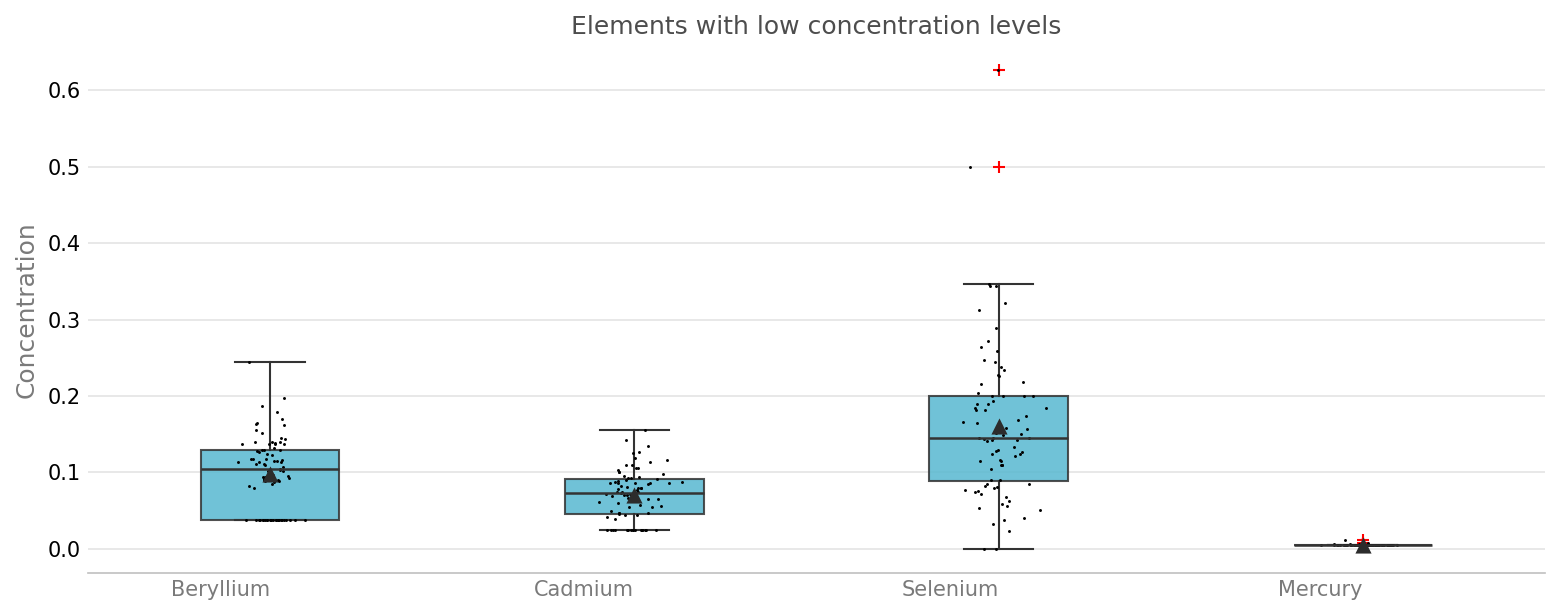

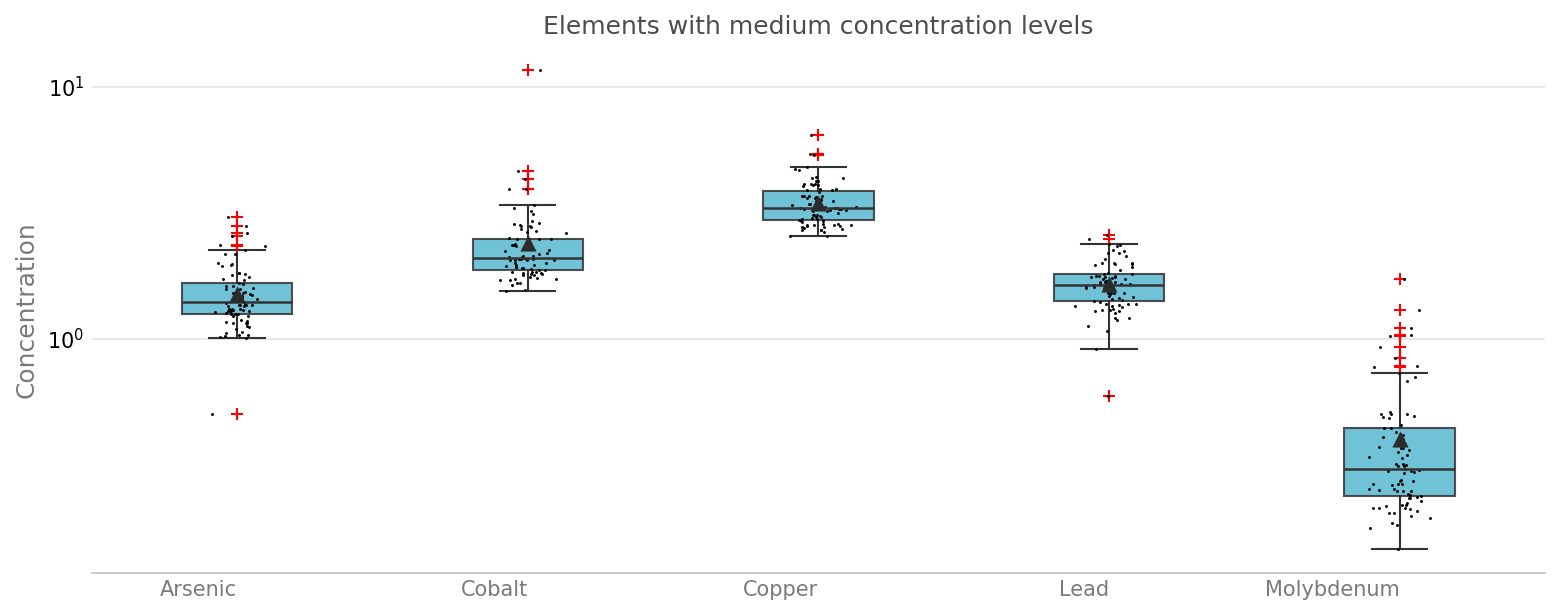

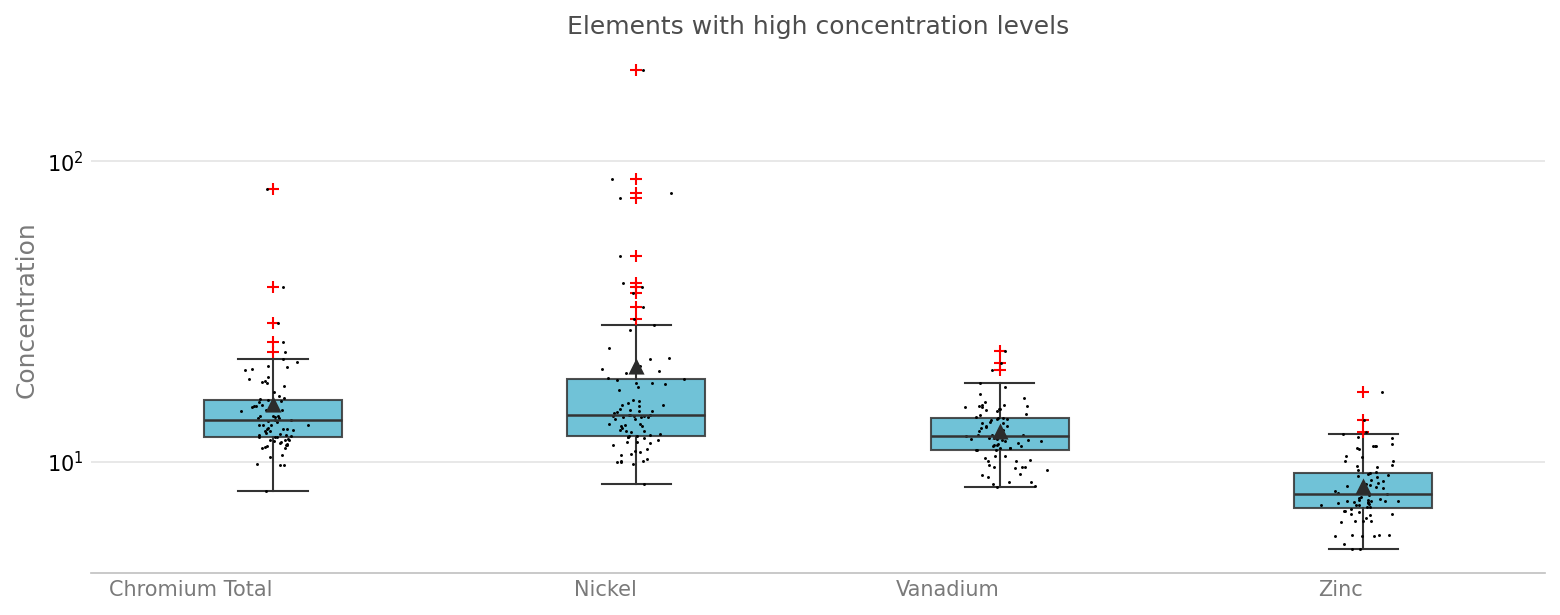

In [31]:
fig, ax = plot_elements_box(low_group,  "Elements with low concentration levels", color=bar_color)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_elements_box1.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_elements_box1.svg"), bbox_inches="tight", pad_inches=0.1)

fig, ax = plot_elements_box(mid_group,  "Elements with medium concentration levels", scale='log',color=bar_color)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_elements_box2.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_elements_box2.svg"), bbox_inches="tight", pad_inches=0.1)

fig, ax = plot_elements_box(high_group, "Elements with high concentration levels", scale='log', color=bar_color)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_elements_box3.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch10_elements_box3.svg"), bbox_inches="tight", pad_inches=0.1)